In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' ## enable xla devices
!nvidia-smi ## check Nvidia GPU details
# !nvidia-smi -L
# !nvidia-smi -q
!lscpu
# !lscpu |grep 'Model name' ## Check CPU details
# !lscpu |grep 'Number of Socket(s):'
# !lscpu | grep 'Core(s) each processor has/per socket:'
# !lscpu | grep 'Number of threads/core:'
!free -h --si | awk  '/Mem:/{print $2}'

# if use tpu
# import tensorflow as tf
# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

/bin/bash: /tmp/ENTER/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Tue Nov  8 23:51:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.76       Driver Version: 515.76       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:2D:00.0 Off |                  Off |
| 30%   36C    P8    24W / 230W |     22MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+------

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=28)
mpl.rc('xtick', labelsize=24)
mpl.rc('ytick', labelsize=24)

import math
import time 
# from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

2022-11-08 23:51:29.325311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 23:51:29.426080: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-08 23:51:29.454880: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-08 23:51:29.960229: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [3]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [4]:
is_gpu = len(tf.config.list_physical_devices('GPU')) > 0 
print(is_gpu)

True


# CFD Parameters

In [5]:
dt = 0.5
dx = 1.0
dy = 1.0
dz = 1.0
Re = 1/20
ub = 1
nx = 1024
ny = 1024
nz = 128
ratio = int(nx/nz)
nlevel = int(math.log(nz, 2)) + 1 
print('Levels of Multigrid:', nlevel)
print('Aspect ratio of Domain:', ratio)

Levels of Multigrid: 8
Aspect ratio of Domain: 8


# Weights of CNNs layers

In [6]:
diffusion = np.loadtxt('diffusion.csv', delimiter = ',')
advx = np.loadtxt('advection_x.csv', delimiter = ',')
advy = np.loadtxt('advection_y.csv', delimiter = ',')
advz = np.loadtxt('advection_z.csv', delimiter = ',')

In [7]:
D = -diffusion*Re/dx**2
adv_x = advx/dx*0.5
adv_y = advy/dy*0.5
adv_z = advz/dz*0.5
A_mg = diffusion/dx**2

In [8]:
# adv_x = np.zeros([1,5,5,5,1])
# adv_xx = np.zeros([1,5,5,5,1])

# adv_y = np.zeros([1,5,5,5,1])
# adv_z = np.zeros([1,5,5,5,1])
# D = np.zeros([1,5,5,5,1])
# A_mg = np.zeros([1,5,5,5,1])

# for i in range(5):
#     print(i,i*5,(i+1)*5)
#     adv_x[0,i,:,:,0] = advx[i*5:(i+1)*5,0]*dt

# adv_x
w_res = np.zeros([1,2,2,2,1])
w_res[0,:,:,:,0] = 0.125

In [9]:
p_div_x1 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]
p_div_x2 = [[-0.056, 0.0, 0.056],
       [-0.22, 0.0, 0.22],
       [-0.056, 0.0, 0.056]]
p_div_x3 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]

p_div_y1 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]
p_div_y2 = [[0.056, 0.22, 0.056],
       [0.0, 0.0, 0.0],
       [-0.056, -0.22, -0.056]]
p_div_y3 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]

p_div_z1 = [[0.014, 0.056, 0.014],
       [0.056, 0.22, 0.056],
       [0.014, 0.056, 0.014]]
p_div_z2 = [[0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0]]
p_div_z3 = [[-0.014, -0.056, -0.014],
       [-0.056, -0.22, -0.056],
       [-0.014, -0.056, -0.014]]
w2 = np.zeros([1,3,3,3,1])
w3 = np.zeros([1,3,3,3,1])
w4 = np.zeros([1,3,3,3,1])

w2[0,0,:,:,0] = np.array(p_div_x1)/dx
w2[0,1,:,:,0] = np.array(p_div_x2)/dx
w2[0,2,:,:,0] = np.array(p_div_x3)/dx

w3[0,0,:,:,0] = np.array(p_div_y1)/dx
w3[0,1,:,:,0] = np.array(p_div_y2)/dx
w3[0,2,:,:,0] = np.array(p_div_y3)/dx 

w4[0,0,:,:,0] = np.array(p_div_z1)/dx 
w4[0,1,:,:,0] = np.array(p_div_z2)/dx
w4[0,2,:,:,0] = np.array(p_div_z3)/dx

In [10]:
kernel_initializer_D = tf.keras.initializers.constant(D)
kernel_initializer_adv_x = tf.keras.initializers.constant(adv_x)
kernel_initializer_adv_y = tf.keras.initializers.constant(adv_y)
kernel_initializer_adv_z = tf.keras.initializers.constant(adv_z)
kernel_initializer_w_res = tf.keras.initializers.constant(w_res)
kernel_initializer_A_mg = tf.keras.initializers.constant(A_mg)

kernel_initializer_adv_x_3 = tf.keras.initializers.constant(w2)
kernel_initializer_adv_y_3 = tf.keras.initializers.constant(w3)
kernel_initializer_adv_z_3 = tf.keras.initializers.constant(w4)

bias_initializer = tf.keras.initializers.constant(np.zeros((1,)))

# Libraries for solving momentum equation

In [11]:
central_xadv_3th = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_adv_x_3,
                                bias_initializer=bias_initializer),
])

central_yadv_3th = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_adv_y_3,
                                bias_initializer=bias_initializer),
])

central_zadv_3th = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_adv_z_3,
                                bias_initializer=bias_initializer),
])

2022-11-08 23:51:40.350962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 23:51:40.394571: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x6dfecb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-08 23:51:40.394615: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
2022-11-08 23:51:40.947328: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22308 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:2d:00.0, compute capability: 8.6
2022-11-08 23:51:40.949457: I tensorflow/compiler/xla/service/ser

In [12]:
central_dif_5th = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=5, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_D,
                                bias_initializer=bias_initializer),
])

central_xadv_5th = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=5, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_adv_x,
                                bias_initializer=bias_initializer),
])

central_yadv_5th = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=5, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_adv_y,
                                bias_initializer=bias_initializer),
])

central_zadv_5th = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=5, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_adv_z,
                                bias_initializer=bias_initializer),
])

# Libraries for multigrid algorithms

In [13]:
for i in range(nlevel):
    locals()['CNN3D_A_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nz*0.5**(nlevel-1-i)), int(ny*0.5**(nlevel-1-i)), int(nx*0.5**(nlevel-1-i)), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=5, strides=1, padding='SAME',         
                                kernel_initializer=kernel_initializer_A_mg,
                                bias_initializer=bias_initializer)
    ])

In [14]:
for i in range(nlevel-1):
    locals()['restrict_'+str(2**(i+1))] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nz*0.5**(nlevel-2-i)), int(ny*0.5**(nlevel-2-i)), int(nx*0.5**(nlevel-2-i)), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_w_res,
                                bias_initializer=bias_initializer),   
    ])    

In [15]:
for i in range(nlevel-1):
    locals()['prolongate_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1*2**i, 1*ratio*2**i, 1*ratio*2**i, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
    ])

# Functions linking to the AI libraries

In [16]:
def boundary_condition_velocity(values_u,values_v,values_w):
    'Define boundary conditions for velocity field'
    tempu = tf.Variable(values_u)
    tempv = tf.Variable(values_v)   
    tempw = tf.Variable(values_w) 
    tempu[0,:,:,0:2,0].assign(tf.Variable(tf.ones((nz,ny,2)))[0,:]*ub) 
    tempv[0,:,:,0:2,0].assign(tf.Variable(tf.zeros((nz,ny,2)))[0,:])    
    tempw[0,:,:,0:2,0].assign(tf.Variable(tf.zeros((nz,ny,2)))[0,:])    

    tempu[0,:,:,nx-2:nx,0].assign(tf.Variable(tf.ones((nz,ny,2)))[0,:]*ub) 
    tempv[0,:,:,nx-2:nx,0].assign(tf.Variable(tf.zeros((nz,ny,2)))[0,:])   
    tempw[0,:,:,nx-2:nx,0].assign(tf.Variable(tf.zeros((nz,ny,2)))[0,:])  
    
    tempu[0,:,0,:,0].assign(tf.Variable(values_u)[0,:,2,:,0]) 
    tempu[0,:,1,:,0].assign(tf.Variable(values_u)[0,:,2,:,0]) 
    tempv[0,:,0:2,:,0].assign(tf.Variable(tf.zeros((nz,2,nx)))[0,:])  
    tempw[0,:,0:2,:,0].assign(tf.Variable(tf.zeros((nz,2,nx)))[0,:])  
        
    tempu[0,:,nx-1,:,0].assign(tf.Variable(values_u)[0,:,nx-3,:,0])    
    tempu[0,:,nx-2,:,0].assign(tf.Variable(values_u)[0,:,nx-3,:,0])    
    tempv[0,:,nx-2:nx,:,0].assign(tf.Variable(tf.zeros((nz,2,nx)))[0,:])     
    tempw[0,:,nx-2:nx,:,0].assign(tf.Variable(tf.zeros((nz,2,nx)))[0,:])  
    
    tempu[0,0:2,:,:,0].assign(tf.Variable(tf.zeros((2,ny,nx)))[0,:])     
    tempv[0,0:2,:,:,0].assign(tf.Variable(tf.zeros((2,ny,nx)))[0,:])  
    tempw[0,0:2,:,:,0].assign(tf.Variable(tf.zeros((2,ny,nx)))[0,:])  
 
    tempu[0,nz-1,:,:,0].assign(tf.Variable(values_u)[0,nz-3,:,:,0])   
    tempu[0,nz-2,:,:,0].assign(tf.Variable(values_u)[0,nz-3,:,:,0])       
    tempv[0,nz-1,:,:,0].assign(tf.Variable(values_v)[0,nz-3,:,:,0]) 
    tempv[0,nz-2,:,:,0].assign(tf.Variable(values_v)[0,nz-3,:,:,0])       
    tempw[0,nz-2:nz,:,:,0].assign(tf.Variable(tf.zeros((2,ny,nx)))[0,:])      
    return tempu,tempv,tempw

def boundary_condition_pressure(values_p,nx):
    'Define boundary conditions for pressure field'
    tempp = tf.Variable(values_p)   
    tempp[0,:,:,nx-2:nx,0].assign(tf.Variable(tf.zeros((nz,ny,2)))[0,:]) 
    tempp[0,:,:,0,0].assign(tf.Variable(values_p)[0,:,:,2,0]) 
    tempp[0,:,:,1,0].assign(tf.Variable(values_p)[0,:,:,2,0])     
    
    tempp[0,:,0,:,0].assign(tf.Variable(values_p)[0,:,2,:,0]) 
    tempp[0,:,1,:,0].assign(tf.Variable(values_p)[0,:,2,:,0])     
    tempp[0,:,nx-1,:,0].assign(tf.Variable(values_p)[0,:,nx-3,:,0])  
    tempp[0,:,nx-2,:,0].assign(tf.Variable(values_p)[0,:,nx-3,:,0]) 

    
    tempp[0,0,:,:,0].assign(tf.Variable(values_p)[0,2,:,:,0]) 
    tempp[0,1,:,:,0].assign(tf.Variable(values_p)[0,2,:,:,0])     
    tempp[0,nz-1,:,:,0].assign(tf.Variable(values_p)[0,nz-3,:,:,0])    
    tempp[0,nz-2,:,:,0].assign(tf.Variable(values_p)[0,nz-3,:,:,0]) 
#     tempp[0,:,:,0:2,0].assign(tf.Variable(values_p)[0,:,:,2,0])
    
#     tempp[0,:,0:2,:,0].assign(tf.Variable(values_p)[0,:,2,:,0])     
#     tempp[0,:,nx-2:nx,:,0].assign(tf.Variable(values_p)[0,:,nx-3,:,0]) 
    
#     tempp[0,0:2,:,:,0].assign(tf.Variable(values_p)[0,2,:,:,0])     
#     tempp[0,nz-2:nz,:,:,0].assign(tf.Variable(values_p)[0,nz-3,:,:,0])  
    return tempp

def boundary_condition_indicator(alpha,nx):   
    'Define boundary conditions for scalar field'
    tempa = tf.Variable(alpha)   
    tempa[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
    tempa[0,:,:,0,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])
    
    tempa[0,:,0,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])     
    tempa[0,:,nx-1,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
    
    tempa[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])     
    tempa[0,nx-1,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
    return tempa

def boundary_condition_source(b,nx):  
    'Define inflow boundary conditions for source terms to'
    'avoid incorrect paddings caused by CNNs'
    tempb = tf.Variable(b)   
    tempb[0,:,:,0,0].assign(tf.Variable(b)[0,:,:,2,0])
    tempb[0,:,:,1,0].assign(tf.Variable(b)[0,:,:,2,0])

    return tempb

def bluff_body(values_u,values_v,values_w,sigma):
    'Immersed Boundary for buildings'
    temp1 = values_u / (1+dt*sigma) 
    temp2 = values_v / (1+dt*sigma)
    temp3 = values_w / (1+dt*sigma) 
    return temp1,temp2,temp3

def save_data(n_out,itime):
    'Save field data'
    if itime % n_out == 0:  
        np.save("../Data_Results/data_SK_quartic/u"+str(itime), arr=values_u[0,:,:,:,0])
        np.save("../Data_Results/data_SK_quartic/v"+str(itime), arr=values_v[0,:,:,:,0])
        np.save("../Data_Results/data_SK_quartic/w"+str(itime), arr=values_w[0,:,:,:,0])
        np.save("../Data_Results/data_SK_quartic/p"+str(itime), arr=values_p[0,:,:,:,0])

In [17]:
def Petrov_Galerkin_dissipation(values_u, values_v, values_w, eplsion_k, sigma):    
    '''Turbulence modelling using Petrov-Galerkin dissipation       
    Input
    ---------------------------------------------------------------------
    values_u: u-component velocity 
    values_v: v-component velocity 
    values_w: w-component velocity 
    eplsion_k: Need to sufficiently large
    
    Output
    ---------------------------------------------------------------------
    k_x: Final diffusion matrix in x direction 
    k_y: Final diffusion matrix in y direction 
    k_z: Final diffusion matrix in z direction 
    '''
    values_u = values_u / (1+dt*sigma) 
    values_v = values_v / (1+dt*sigma)     
    values_w = values_w / (1+dt*sigma) 
      
    k_u = 8 * 0.25 * abs(1/3*
                               (abs(values_u) + abs(values_v) + abs(values_w)) * 
                               central_dif_5th(values_u)) / (eplsion_k + 
                               (abs(central_xadv_5th(values_u)) + 
                               abs(central_yadv_5th(values_u)) + 
                               abs(central_zadv_5th(values_u)))/3)
    
    k_v = 8 * 0.25 * abs(1/3*
                               (abs(values_u) + abs(values_v) + abs(values_w)) * 
                               central_dif_5th(values_v)) / (eplsion_k + 
                               (abs(central_xadv_5th(values_v)) + 
                               abs(central_yadv_5th(values_v)) + 
                               abs(central_zadv_5th(values_v)))/3)
    
    k_w = 8 * 0.25 * abs(1/3*
                               (abs(values_u) + abs(values_v) + abs(values_w)) * 
                               central_dif_5th(values_w)) / (eplsion_k + 
                               (abs(central_xadv_5th(values_w)) + 
                               abs(central_yadv_5th(values_w)) + 
                               abs(central_zadv_5th(values_w)))/3)
       
    k_u = tf.math.minimum(k_u, tf.ones(input_shape)/dt*0.25*2) / (1+dt*sigma) 
    k_v = tf.math.minimum(k_v, tf.ones(input_shape)/dt*0.25*2) / (1+dt*sigma)     
    k_w = tf.math.minimum(k_w, tf.ones(input_shape)/dt*0.25*2) / (1+dt*sigma)    
    
    
    k_x = 3*0.5*(k_u*central_dif_5th(values_u) +
                central_dif_5th(values_u*k_u) -
                values_u*central_dif_5th(k_u))


    k_y = 3*0.5*(k_v*central_dif_5th(values_v) + 
                central_dif_5th(values_v*k_v) -
                values_v*central_dif_5th(k_v))


    k_z = 3*0.5*(k_w*central_dif_5th(values_w) + 
                central_dif_5th(values_w*k_w) -
                values_w*central_dif_5th(k_w))

    return k_x, k_y, k_z

In [18]:
def Petrov_Galerkin_dissipation_high(values_u, values_v, values_w, eplsion_k, sigma):    
    '''Turbulence modelling using Petrov-Galerkin dissipation       
    Input
    ---------------------------------------------------------------------
    values_u: u-component velocity 
    values_v: v-component velocity 
    values_w: w-component velocity 
    eplsion_k: Need to sufficiently large
    
    Output
    ---------------------------------------------------------------------
    k_x: Final diffusion matrix in x direction 
    k_y: Final diffusion matrix in y direction 
    k_z: Final diffusion matrix in z direction 
    '''
    values_u = values_u / (1+dt*sigma) 
    values_v = values_v / (1+dt*sigma)     
    values_w = values_w / (1+dt*sigma) 
      
    k_u = 8*0.25*abs(values_u*(central_xadv_5th(values_u)-central_xadv_3th(values_u))+
                     values_v*(central_yadv_5th(values_u)-central_yadv_3th(values_u))+
                     values_w*(central_zadv_5th(values_u)-central_zadv_3th(values_u)))/ \
                     (eplsion_k+(abs(central_xadv_5th(values_u))+ \
                      abs(central_yadv_5th(values_u))+abs(central_zadv_5th(values_u)))/3)

    k_v = 8*0.25*abs(values_u*(central_xadv_5th(values_v)-central_xadv_3th(values_v))+
                     values_v*(central_yadv_5th(values_v)-central_yadv_3th(values_v))+
                     values_w*(central_zadv_5th(values_v)-central_zadv_3th(values_v)))/ \
                     (eplsion_k+(abs(central_xadv_5th(values_v))+ \
                      abs(central_yadv_5th(values_v))+abs(central_zadv_5th(values_v)))/3)
    
    k_w = 8*0.25*abs(values_u*(central_xadv_5th(values_w)-central_xadv_3th(values_w))+
                     values_v*(central_yadv_5th(values_w)-central_yadv_3th(values_w))+
                     values_w*(central_zadv_5th(values_w)-central_zadv_3th(values_w)))/ \
                     (eplsion_k+(abs(central_xadv_5th(values_w))+ \
                      abs(central_yadv_5th(values_w))+abs(central_zadv_5th(values_w)))/3)
    
    
    
    
#     k_v = 40 * 0.25 * abs(1/3*
#                                (abs(values_u) + abs(values_v) + abs(values_w)) * 
#                                central_dif_5th(values_v)) / (eplsion_k + 
#                                (abs(central_xadv_5th(values_v)) + 
#                                abs(central_yadv_5th(values_v)) + 
#                                abs(central_zadv_5th(values_v)))/3)
    
#     k_w = 40 * 0.25 * abs(1/3*
#                                (abs(values_u) + abs(values_v) + abs(values_w)) * 
#                                central_dif_5th(values_w)) / (eplsion_k + 
#                                (abs(central_xadv_5th(values_w)) + 
#                                abs(central_yadv_5th(values_w)) + 
#                                abs(central_zadv_5th(values_w)))/3)
       
    k_u = tf.math.minimum(k_u, tf.ones(input_shape)/dt*0.25) / (1+dt*sigma) 
    k_v = tf.math.minimum(k_v, tf.ones(input_shape)/dt*0.25) / (1+dt*sigma)     
    k_w = tf.math.minimum(k_w, tf.ones(input_shape)/dt*0.25) / (1+dt*sigma)    
    
    
    k_x = 3*0.5*(k_u*central_dif_5th(values_u) +
                central_dif_5th(values_u*k_u) -
                values_u*central_dif_5th(k_u))


    k_y = 3*0.5*(k_v*central_dif_5th(values_v) + 
                central_dif_5th(values_v*k_v) -
                values_v*central_dif_5th(k_v))


    k_z = 3*0.5*(k_w*central_dif_5th(values_w) + 
                central_dif_5th(values_w*k_w) -
                values_w*central_dif_5th(k_w))

    return k_x, k_y, k_z

# Initialise

============== Numerical parameters ===============
Mesh resolution: (1, 128, 1024, 1024, 1)
Time step: 6000
Initial time: 0
Restart solver!
Solving single-phase flows!
Switch on IBM solver!


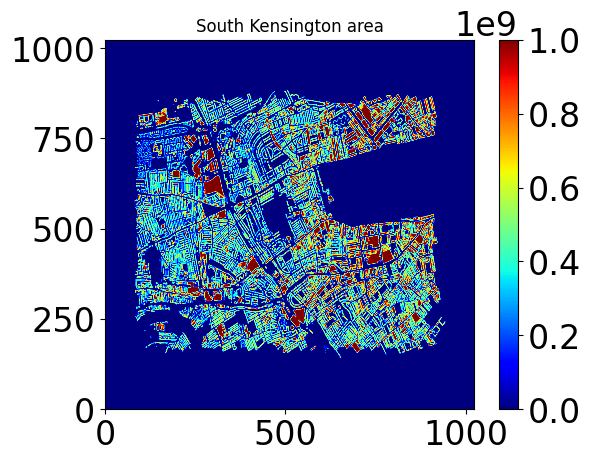

In [19]:
#################### Create field #####£###############
input_shape = (1,nz,ny,nx,1)
values_u = tf.zeros(input_shape)
values_v = tf.zeros(input_shape)
values_w = tf.zeros(input_shape)
values_p = tf.zeros(input_shape)
#######################################################
################# Numerical parameters ################
multi_itr = 4               # Iterations of multi-grid 
j_itr = 1                   # Iterations of Jacobi 
ntime = 6000                 # Time steps
n_out = 500                 # Results output
nrestart = 0                # Last time step for restart
ctime_old = 0               # Last ctime for restart
mgsolver = True             # Multigrid solver
LSCALAR = False              # Scalar transport 
LMTI = False                 # Non density for multiphase flows
LIBM = True                # Immersed boundary method 
nsafe = 0.5                 # Continuty equation residuals
ctime = 0                   # Initialise ctime   
save_fig = True             # Save results
Restart = True             # Restart
eplsion_k = 1e-03
################# Physical parameters #################
rho_l = 1000                # Density of liquid phase 
rho_g = 980                 # Density of gas phase 
g_x = 0;g_y = 0;g_z = -9.8   # Gravity acceleration (m/s2) 
#######################################################
print('============== Numerical parameters ===============')
print('Mesh resolution:', values_v.shape)
print('Time step:', ntime)
print('Initial time:', ctime)
#######################################################
################# Only for restart ####################
if Restart == True:
    temp1 = np.load('../Data_Results/data_SK_quartic/u500.npy').astype('float32')
    temp2 = np.load('../Data_Results/data_SK_quartic/v500.npy').astype('float32')
    temp3 = np.load('../Data_Results/data_SK_quartic/w500.npy').astype('float32')
    temp4 = np.load('../Data_Results/data_SK_quartic/p500.npy').astype('float32')
    values_u = tf.Variable(values_u)[0,:,:,:,0].assign(tf.convert_to_tensor(temp1))
    values_v = tf.Variable(values_v)[0,:,:,:,0].assign(tf.convert_to_tensor(temp2))
    values_w = tf.Variable(values_w)[0,:,:,:,0].assign(tf.convert_to_tensor(temp3))
    values_p = tf.Variable(values_p)[0,:,:,:,0].assign(tf.convert_to_tensor(temp4))
    nrestart = 500
    ctime_old = nrestart*dt
    print('Restart solver!')
#######################################################    
################# Only for scalar #####################
if LSCALAR == True:
    alpha = np.zeros(input_shape).astype('float32')
    alpha[0,0:64,:,:,0] = 0
    alpha[0,64:128,:,:,0] = 1.0
    alpha = tf.convert_to_tensor(alpha)
    print('Switch on scalar filed solver!')
#######################################################
################# Only for scalar #####################
if LMTI == True:
    rho = tf.zeros(input_shape)
    rho = alpha*rho_l + (1-alpha)*rho_g
    print('Solving multiphase flows!')
else:
    rho = tf.ones(input_shape)
    print('Solving single-phase flows!')
################# Only for IBM ########################
if LIBM == True:
    mesh = np.load('../Mesh_SK_London/INHALE_1280.npy')
    sigma = np.zeros(input_shape).astype('float32')
    for i in range(1,nx-1):
        for j in range(1,ny-1):
            for k in range(1,nz-1):
                if mesh[0][i+128][j+128][k][0] == 0:
                    sigma[0][k][j][i][0] = 1000000000  
    sigma = tf.convert_to_tensor(sigma)
    print('Switch on IBM solver!')
    print('===================================================')
    plt.imshow(sigma[0,1,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('South Kensington area')
    plt.gca().invert_yaxis()
#######################################################

# AI-HFM Solver

In [20]:
start = time.time()
for itime in range(1,ntime+1): 
    ctime = ctime + dt 
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w)
    values_p = boundary_condition_pressure(values_p,nx)
# Petrov-Galerkin dissipation
    [k_x,k_y,k_z] = Petrov_Galerkin_dissipation(values_u, values_v, values_w, eplsion_k, sigma)
# Momentum equation 
    a_u = k_x*dt - \
    values_u*central_xadv_5th(values_u)*dt - \
    values_v*central_yadv_5th(values_u)*dt - \
    values_w*central_zadv_5th(values_u)*dt
    b_u = 0.5*a_u + values_u
    a_v = k_y*dt - \
    values_u*central_xadv_5th(values_v)*dt - \
    values_v*central_yadv_5th(values_v)*dt - \
    values_w*central_zadv_5th(values_v)*dt
    b_v = 0.5*a_v + values_v
    a_w = k_z*dt - \
    values_u*central_xadv_5th(values_w)*dt - \
    values_v*central_yadv_5th(values_w)*dt - \
    values_w*central_zadv_5th(values_w)*dt 
    b_w = 0.5*a_w + values_w

    [b_u,b_v,b_w] = boundary_condition_velocity(b_u,b_v,b_w)
    [kb_x,kb_y,kb_z] = Petrov_Galerkin_dissipation(b_u, b_v, b_w, eplsion_k, sigma)

    c_u = kb_x*dt - \
    b_u*central_xadv_5th(b_u)*dt - \
    b_v*central_yadv_5th(b_u)*dt - \
    b_w*central_zadv_5th(b_u)*dt
    values_u = values_u + c_u      
    c_v = kb_y*dt - \
    b_u*central_xadv_5th(b_v)*dt - \
    b_v*central_yadv_5th(b_v)*dt - \
    b_w*central_zadv_5th(b_v)*dt 
    values_v = values_v + c_v
    c_w = kb_z*dt - \
    b_u*central_xadv_5th(b_w)*dt - \
    b_v*central_yadv_5th(b_w)*dt - \
    b_w*central_zadv_5th(b_w)*dt 
    values_w = values_w + c_w    
# Passive tracer scalar transport
    if LSCALAR == True:
        a_t = CNN3D_central_2nd_dif(alpha) - \
        values_u*CNN3D_central_2nd_xadv(alpha) - \
        values_v*CNN3D_central_2nd_yadv(alpha) - \
        values_w*CNN3D_central_2nd_zadv(alpha)
        alpha = alpha + a_t
        alpha = boundary_condition_indicator(alpha,nx)
    if LMTI == True:
        rho = alpha*rho_l + (1-alpha)*rho_g
# IBM
#     if LIBM == True:
    [values_u,values_v,values_w] = bluff_body(values_u,values_v,values_w,sigma)
# gradp            
    values_u = values_u - central_xadv_5th(values_p)*dt
    values_v = values_v - central_yadv_5th(values_p)*dt  
    values_w = values_w - central_zadv_5th(values_p)*dt     
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w)
# possion equation (multi-grid) A*P = Su
    b = -(central_xadv_5th(values_u) + \
          central_yadv_5th(values_v) + \
          central_zadv_5th(values_w))/dt
    b = boundary_condition_source(b,nx)
    if mgsolver == True:
        for multi_grid in range(multi_itr): 
            w_1 = tf.zeros([1,1,ratio,ratio,1])
            r = CNN3D_A_128(values_p) - b   
            r = tf.Variable(r)[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:]) 
#             r_256 = CNN3D_res_512(r) 
#             r_128 = CNN3D_res_256(r_256) 
            r_64 = restrict_128(r) 
            r_32 = restrict_64(r_64) 
            r_16 = restrict_32(r_32) 
            r_8 = restrict_16(r_16) 
            r_4 = restrict_8(r_8) 
            r_2 = restrict_4(r_4) 
            r_1 = restrict_2(r_2)
            for Jacobi in range(j_itr):
                w_1 = (w_1 - CNN3D_A_1(w_1)/A_mg[12,2] + r_1/A_mg[12,2])
            w_2 = prolongate_1(w_1)             
            for Jacobi in range(j_itr):
                w_2 = (w_2 - CNN3D_A_2(w_2)/A_mg[12,2] + r_2/A_mg[12,2])
            w_4 = prolongate_2(w_2) 
            for Jacobi in range(j_itr):
                w_4 = (w_4 - CNN3D_A_4(w_4)/A_mg[12,2] + r_4/A_mg[12,2])
            w_8 = prolongate_4(w_4) 
            for Jacobi in range(j_itr):
                w_8 = (w_8 - CNN3D_A_8(w_8)/A_mg[12,2] + r_8/A_mg[12,2])
            w_16 = prolongate_8(w_8) 
            for Jacobi in range(j_itr):
                w_16 = (w_16 - CNN3D_A_16(w_16)/A_mg[12,2] + r_16/A_mg[12,2])
            w_32 = prolongate_16(w_16) 
            for Jacobi in range(j_itr):
                w_32 = (w_32 - CNN3D_A_32(w_32)/A_mg[12,2] + r_32/A_mg[12,2])
            w_64 = prolongate_32(w_32) 
            for Jacobi in range(j_itr):
                w_64 = (w_64 - CNN3D_A_64(w_64)/A_mg[12,2] + r_64/A_mg[12,2])
            w_128 = prolongate_64(w_64) 
#             for Jacobi in range(j_itr):
#                 w_128 = (w_128 - CNN3D_A_128(w_128)/w5[0,1,1,1,0] + r_128/w5[0,1,1,1,0] )
#             w_256 = CNN3D_prol_128(w_128)
#             for Jacobi in range(j_itr):
#                 w_256 = (w_256 - CNN3D_A_256(w_256)/w5[0,1,1,1,0] + r_256/w5[0,1,1,1,0] )
#             w_512 = CNN3D_prol_256(w_256)
            values_p = values_p - w_128
            values_p = tf.Variable(values_p)[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:])         
            values_p = (values_p - CNN3D_A_128(values_p)/A_mg[12,2] + b/A_mg[12,2])          
# correct
    values_p = boundary_condition_pressure(values_p,nx)
    values_u = values_u - central_xadv_5th(values_p)*dt
    values_v = values_v - central_yadv_5th(values_p)*dt  
    values_w = values_w - central_zadv_5th(values_p)*dt      
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w)
#     if LIBM == True:
    [values_u,values_v,values_w] = bluff_body(values_u,values_v,values_w,sigma)
# output   
    print('Time step:', itime) 
    print('Pressure error:', np.max(w_128), 'cty equation residual:', np.max(r))
    print('========================================================')
    if np.max(np.abs(w_128)) > nsafe:
        print('Not converged !!!!!!')
        break
    if save_fig == True:
        save_data(n_out,itime+nrestart)
end = time.time()
print('time',(end-start))

2022-11-08 23:57:26.435092: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-08 23:57:27.324940: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-08 23:57:27.325813: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-08 23:57:27.325869: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-08 23:57:27.326827: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-08 23:57:27.326924: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Time step: 1
Pressure error: 0.021974985 cty equation residual: 0.12892339
Time step: 2
Pressure error: 0.018371683 cty equation residual: 0.10184601
Time step: 3
Pressure error: 0.01753846 cty equation residual: 0.10084289
Time step: 4
Pressure error: 0.017501226 cty equation residual: 0.10115367
Time step: 5
Pressure error: 0.017504776 cty equation residual: 0.10130149
Time step: 6
Pressure error: 0.017506769 cty equation residual: 0.101324975
Time step: 7
Pressure error: 0.017504416 cty equation residual: 0.10128522
Time step: 8
Pressure error: 0.01749879 cty equation residual: 0.10121751
Time step: 9
Pressure error: 0.017491119 cty equation residual: 0.10114092
Time step: 10
Pressure error: 0.01748237 cty equation residual: 0.10106355
Time step: 11
Pressure error: 0.017473167 cty equation residual: 0.10098839
Time step: 12
Pressure error: 0.01746364 cty equation residual: 0.100916445
Time step: 13
Pressure error: 0.017454058 cty equation residual: 0.10084683
Time step: 14
Pressure 

Time step: 63
Pressure error: 0.017105376 cty equation residual: 0.098384105
Time step: 64
Pressure error: 0.017101672 cty equation residual: 0.098374225
Time step: 65
Pressure error: 0.017098026 cty equation residual: 0.09836418
Time step: 66
Pressure error: 0.017094389 cty equation residual: 0.09835441
Time step: 67
Pressure error: 0.01709076 cty equation residual: 0.09834441
Time step: 68
Pressure error: 0.017087178 cty equation residual: 0.09833495
Time step: 69
Pressure error: 0.01708363 cty equation residual: 0.09832486
Time step: 70
Pressure error: 0.01708017 cty equation residual: 0.09831478
Time step: 71
Pressure error: 0.017076747 cty equation residual: 0.09830581
Time step: 72
Pressure error: 0.017073406 cty equation residual: 0.098296
Time step: 73
Pressure error: 0.017070105 cty equation residual: 0.09828635
Time step: 74
Pressure error: 0.017066892 cty equation residual: 0.098276615
Time step: 75
Pressure error: 0.017063685 cty equation residual: 0.09826746
Time step: 76


Time step: 125
Pressure error: 0.016940402 cty equation residual: 0.09782356
Time step: 126
Pressure error: 0.016938144 cty equation residual: 0.09781484
Time step: 127
Pressure error: 0.016935878 cty equation residual: 0.09780629
Time step: 128
Pressure error: 0.016933635 cty equation residual: 0.097798064
Time step: 129
Pressure error: 0.016931377 cty equation residual: 0.09778917
Time step: 130
Pressure error: 0.01692912 cty equation residual: 0.09778039
Time step: 131
Pressure error: 0.016926844 cty equation residual: 0.09777216
Time step: 132
Pressure error: 0.016924601 cty equation residual: 0.09776386
Time step: 133
Pressure error: 0.016922373 cty equation residual: 0.09775511
Time step: 134
Pressure error: 0.016920121 cty equation residual: 0.09774661
Time step: 135
Pressure error: 0.016917916 cty equation residual: 0.09773801
Time step: 136
Pressure error: 0.016915686 cty equation residual: 0.09772919
Time step: 137
Pressure error: 0.016913498 cty equation residual: 0.09772101

Pressure error: 0.016829023 cty equation residual: 0.097311586
Time step: 187
Pressure error: 0.0168275 cty equation residual: 0.097303465
Time step: 188
Pressure error: 0.016825948 cty equation residual: 0.09729559
Time step: 189
Pressure error: 0.01682437 cty equation residual: 0.097287476
Time step: 190
Pressure error: 0.016822811 cty equation residual: 0.09727955
Time step: 191
Pressure error: 0.01682123 cty equation residual: 0.097271465
Time step: 192
Pressure error: 0.016819634 cty equation residual: 0.097263575
Time step: 193
Pressure error: 0.01681802 cty equation residual: 0.09725548
Time step: 194
Pressure error: 0.016816355 cty equation residual: 0.0972473
Time step: 195
Pressure error: 0.016814694 cty equation residual: 0.0972396
Time step: 196
Pressure error: 0.016813003 cty equation residual: 0.097231545
Time step: 197
Pressure error: 0.016811296 cty equation residual: 0.097223446
Time step: 198
Pressure error: 0.01680957 cty equation residual: 0.097215526
Time step: 199

Time step: 248
Pressure error: 0.016678495 cty equation residual: 0.09682625
Time step: 249
Pressure error: 0.01667558 cty equation residual: 0.096818395
Time step: 250
Pressure error: 0.016672712 cty equation residual: 0.09681082
Time step: 251
Pressure error: 0.016669866 cty equation residual: 0.09680333
Time step: 252
Pressure error: 0.016667068 cty equation residual: 0.09679534
Time step: 253
Pressure error: 0.016664349 cty equation residual: 0.0967878
Time step: 254
Pressure error: 0.016661657 cty equation residual: 0.09678025
Time step: 255
Pressure error: 0.016658984 cty equation residual: 0.096772775
Time step: 256
Pressure error: 0.016656434 cty equation residual: 0.096764706
Time step: 257
Pressure error: 0.016653925 cty equation residual: 0.096757196
Time step: 258
Pressure error: 0.016651463 cty equation residual: 0.09674986
Time step: 259
Pressure error: 0.016649038 cty equation residual: 0.0967421
Time step: 260
Pressure error: 0.016646683 cty equation residual: 0.0967340

Time step: 310
Pressure error: 0.016556036 cty equation residual: 0.096370436
Time step: 311
Pressure error: 0.016553639 cty equation residual: 0.096362986
Time step: 312
Pressure error: 0.016551211 cty equation residual: 0.09635586
Time step: 313
Pressure error: 0.016548794 cty equation residual: 0.09634852
Time step: 314
Pressure error: 0.01654631 cty equation residual: 0.096340984
Time step: 315
Pressure error: 0.016543824 cty equation residual: 0.09633429
Time step: 316
Pressure error: 0.016541297 cty equation residual: 0.09632678
Time step: 317
Pressure error: 0.016538752 cty equation residual: 0.0963194
Time step: 318
Pressure error: 0.016536208 cty equation residual: 0.09631212
Time step: 319
Pressure error: 0.01653368 cty equation residual: 0.09630465
Time step: 320
Pressure error: 0.016531117 cty equation residual: 0.0962973
Time step: 321
Pressure error: 0.01652857 cty equation residual: 0.09628976
Time step: 322
Pressure error: 0.01652601 cty equation residual: 0.09628276
Ti

Pressure error: 0.016432228 cty equation residual: 0.09593664
Time step: 372
Pressure error: 0.016430542 cty equation residual: 0.095930085
Time step: 373
Pressure error: 0.016428772 cty equation residual: 0.09592344
Time step: 374
Pressure error: 0.016427016 cty equation residual: 0.09591622
Time step: 375
Pressure error: 0.016425205 cty equation residual: 0.09590975
Time step: 376
Pressure error: 0.016423393 cty equation residual: 0.09590302
Time step: 377
Pressure error: 0.01642152 cty equation residual: 0.09589579
Time step: 378
Pressure error: 0.016419617 cty equation residual: 0.09588908
Time step: 379
Pressure error: 0.016417706 cty equation residual: 0.095882274
Time step: 380
Pressure error: 0.016415736 cty equation residual: 0.095875755
Time step: 381
Pressure error: 0.016413756 cty equation residual: 0.09586881
Time step: 382
Pressure error: 0.016411737 cty equation residual: 0.0958619
Time step: 383
Pressure error: 0.016409652 cty equation residual: 0.0958555
Time step: 384

Time step: 433
Pressure error: 0.01628642 cty equation residual: 0.09552722
Time step: 434
Pressure error: 0.01628401 cty equation residual: 0.095521286
Time step: 435
Pressure error: 0.016281614 cty equation residual: 0.095514596
Time step: 436
Pressure error: 0.016279202 cty equation residual: 0.09550816
Time step: 437
Pressure error: 0.016276801 cty equation residual: 0.09550204
Time step: 438
Pressure error: 0.016274434 cty equation residual: 0.09549566
Time step: 439
Pressure error: 0.016272042 cty equation residual: 0.095489174
Time step: 440
Pressure error: 0.016269661 cty equation residual: 0.09548318
Time step: 441
Pressure error: 0.016267288 cty equation residual: 0.09547693
Time step: 442
Pressure error: 0.016264915 cty equation residual: 0.095470496
Time step: 443
Pressure error: 0.016262569 cty equation residual: 0.09546386
Time step: 444
Pressure error: 0.016260196 cty equation residual: 0.09545801
Time step: 445
Pressure error: 0.016257841 cty equation residual: 0.095451

Pressure error: 0.016139608 cty equation residual: 0.09513911
Time step: 495
Pressure error: 0.01613715 cty equation residual: 0.09513257
Time step: 496
Pressure error: 0.016134681 cty equation residual: 0.09512588
Time step: 497
Pressure error: 0.016132258 cty equation residual: 0.095118865
Time step: 498
Pressure error: 0.016129782 cty equation residual: 0.09511267
Time step: 499
Pressure error: 0.01612731 cty equation residual: 0.09510663
Time step: 500
Pressure error: 0.01612486 cty equation residual: 0.095099725
Time step: 501
Pressure error: 0.016122397 cty equation residual: 0.09509285
Time step: 502
Pressure error: 0.01611995 cty equation residual: 0.09508639
Time step: 503
Pressure error: 0.016117517 cty equation residual: 0.09507996
Time step: 504
Pressure error: 0.016115036 cty equation residual: 0.09507333
Time step: 505
Pressure error: 0.016112592 cty equation residual: 0.09506635
Time step: 506
Pressure error: 0.016110152 cty equation residual: 0.09505978
Time step: 507
P

Time step: 556
Pressure error: 0.015987806 cty equation residual: 0.09472953
Time step: 557
Pressure error: 0.015985357 cty equation residual: 0.09472318
Time step: 558
Pressure error: 0.015982926 cty equation residual: 0.09471617
Time step: 559
Pressure error: 0.015980456 cty equation residual: 0.09470991
Time step: 560
Pressure error: 0.015978018 cty equation residual: 0.09470292
Time step: 561
Pressure error: 0.01597555 cty equation residual: 0.09469648
Time step: 562
Pressure error: 0.01597308 cty equation residual: 0.09469008
Time step: 563
Pressure error: 0.015970655 cty equation residual: 0.0946832
Time step: 564
Pressure error: 0.015968198 cty equation residual: 0.09467657
Time step: 565
Pressure error: 0.015965728 cty equation residual: 0.09467051
Time step: 566
Pressure error: 0.0159633 cty equation residual: 0.09466345
Time step: 567
Pressure error: 0.015960842 cty equation residual: 0.09465717
Time step: 568
Pressure error: 0.015958417 cty equation residual: 0.09465024
Time

Time step: 618
Pressure error: 0.015836226 cty equation residual: 0.09431938
Time step: 619
Pressure error: 0.01583377 cty equation residual: 0.09431308
Time step: 620
Pressure error: 0.015831266 cty equation residual: 0.09430643
Time step: 621
Pressure error: 0.01582878 cty equation residual: 0.09429994
Time step: 622
Pressure error: 0.015826289 cty equation residual: 0.094293214
Time step: 623
Pressure error: 0.015823845 cty equation residual: 0.09428673
Time step: 624
Pressure error: 0.015821325 cty equation residual: 0.09427992
Time step: 625
Pressure error: 0.015818823 cty equation residual: 0.0942734
Time step: 626
Pressure error: 0.015816353 cty equation residual: 0.09426696
Time step: 627
Pressure error: 0.015813876 cty equation residual: 0.09426002
Time step: 628
Pressure error: 0.015811373 cty equation residual: 0.094253495
Time step: 629
Pressure error: 0.0158089 cty equation residual: 0.0942469
Time step: 630
Pressure error: 0.015806358 cty equation residual: 0.09424023
Tim

Time step: 680
Pressure error: 0.015685767 cty equation residual: 0.093908176
Time step: 681
Pressure error: 0.015683418 cty equation residual: 0.093901485
Time step: 682
Pressure error: 0.015681025 cty equation residual: 0.09389452
Time step: 683
Pressure error: 0.015678663 cty equation residual: 0.093888216
Time step: 684
Pressure error: 0.015676297 cty equation residual: 0.09388115
Time step: 685
Pressure error: 0.015673913 cty equation residual: 0.093874775
Time step: 686
Pressure error: 0.015671514 cty equation residual: 0.09386792
Time step: 687
Pressure error: 0.015669126 cty equation residual: 0.09386128
Time step: 688
Pressure error: 0.015666736 cty equation residual: 0.09385437
Time step: 689
Pressure error: 0.015664363 cty equation residual: 0.093847275
Time step: 690
Pressure error: 0.01566201 cty equation residual: 0.09384091
Time step: 691
Pressure error: 0.015659668 cty equation residual: 0.09383429
Time step: 692
Pressure error: 0.01565732 cty equation residual: 0.09382

Pressure error: 0.015545293 cty equation residual: 0.093490414
Time step: 742
Pressure error: 0.015543095 cty equation residual: 0.09348323
Time step: 743
Pressure error: 0.015540862 cty equation residual: 0.09347649
Time step: 744
Pressure error: 0.0155386515 cty equation residual: 0.093469284
Time step: 745
Pressure error: 0.0155364275 cty equation residual: 0.09346205
Time step: 746
Pressure error: 0.015534256 cty equation residual: 0.09345488
Time step: 747
Pressure error: 0.015532083 cty equation residual: 0.09344797
Time step: 748
Pressure error: 0.015529878 cty equation residual: 0.093440846
Time step: 749
Pressure error: 0.015527728 cty equation residual: 0.093433805
Time step: 750
Pressure error: 0.015525561 cty equation residual: 0.09342665
Time step: 751
Pressure error: 0.01552338 cty equation residual: 0.09341973
Time step: 752
Pressure error: 0.015521202 cty equation residual: 0.093412735
Time step: 753
Pressure error: 0.015519001 cty equation residual: 0.0934053
Time step

Time step: 803
Pressure error: 0.015413542 cty equation residual: 0.09304758
Time step: 804
Pressure error: 0.0154115 cty equation residual: 0.093040116
Time step: 805
Pressure error: 0.015409511 cty equation residual: 0.093032934
Time step: 806
Pressure error: 0.015407468 cty equation residual: 0.093025714
Time step: 807
Pressure error: 0.015405417 cty equation residual: 0.093018524
Time step: 808
Pressure error: 0.015403422 cty equation residual: 0.09301129
Time step: 809
Pressure error: 0.015401448 cty equation residual: 0.09300393
Time step: 810
Pressure error: 0.01539948 cty equation residual: 0.09299687
Time step: 811
Pressure error: 0.015397528 cty equation residual: 0.09298935
Time step: 812
Pressure error: 0.015395535 cty equation residual: 0.09298225
Time step: 813
Pressure error: 0.015393556 cty equation residual: 0.0929754
Time step: 814
Pressure error: 0.015391583 cty equation residual: 0.092967995
Time step: 815
Pressure error: 0.015389632 cty equation residual: 0.0929610

Pressure error: 0.015317054 cty equation residual: 0.09260393
Time step: 865
Pressure error: 0.015315568 cty equation residual: 0.09259685
Time step: 866
Pressure error: 0.015313981 cty equation residual: 0.092589095
Time step: 867
Pressure error: 0.015312347 cty equation residual: 0.09258199
Time step: 868
Pressure error: 0.01531065 cty equation residual: 0.092574716
Time step: 869
Pressure error: 0.01530887 cty equation residual: 0.09256709
Time step: 870
Pressure error: 0.01530705 cty equation residual: 0.09255975
Time step: 871
Pressure error: 0.015305189 cty equation residual: 0.092552505
Time step: 872
Pressure error: 0.015303293 cty equation residual: 0.092545085
Time step: 873
Pressure error: 0.0153012965 cty equation residual: 0.09253765
Time step: 874
Pressure error: 0.015299236 cty equation residual: 0.09253034
Time step: 875
Pressure error: 0.01529709 cty equation residual: 0.09252286
Time step: 876
Pressure error: 0.015294876 cty equation residual: 0.09251544
Time step: 87

Time step: 926
Pressure error: 0.015165728 cty equation residual: 0.09212457
Time step: 927
Pressure error: 0.015164064 cty equation residual: 0.092116825
Time step: 928
Pressure error: 0.015162453 cty equation residual: 0.09210887
Time step: 929
Pressure error: 0.01516084 cty equation residual: 0.09210087
Time step: 930
Pressure error: 0.015159201 cty equation residual: 0.092092864
Time step: 931
Pressure error: 0.015157569 cty equation residual: 0.092085004
Time step: 932
Pressure error: 0.015156023 cty equation residual: 0.09207689
Time step: 933
Pressure error: 0.015154573 cty equation residual: 0.09206872
Time step: 934
Pressure error: 0.015153174 cty equation residual: 0.09206085
Time step: 935
Pressure error: 0.015151861 cty equation residual: 0.09205301
Time step: 936
Pressure error: 0.01515054 cty equation residual: 0.092045166
Time step: 937
Pressure error: 0.015149208 cty equation residual: 0.09203714
Time step: 938
Pressure error: 0.015147852 cty equation residual: 0.092029

Pressure error: 0.015063517 cty equation residual: 0.09163551
Time step: 988
Pressure error: 0.015059817 cty equation residual: 0.09162718
Time step: 989
Pressure error: 0.015056013 cty equation residual: 0.09161927
Time step: 990
Pressure error: 0.015052096 cty equation residual: 0.09161091
Time step: 991
Pressure error: 0.015048162 cty equation residual: 0.09160284
Time step: 992
Pressure error: 0.015044242 cty equation residual: 0.09159472
Time step: 993
Pressure error: 0.015040204 cty equation residual: 0.0915867
Time step: 994
Pressure error: 0.015036151 cty equation residual: 0.09157826
Time step: 995
Pressure error: 0.015031999 cty equation residual: 0.09156999
Time step: 996
Pressure error: 0.015027791 cty equation residual: 0.09156207
Time step: 997
Pressure error: 0.015023544 cty equation residual: 0.09155402
Time step: 998
Pressure error: 0.015019244 cty equation residual: 0.09154601
Time step: 999
Pressure error: 0.015014925 cty equation residual: 0.091537505
Time step: 100

Time step: 1048
Pressure error: 0.014833463 cty equation residual: 0.09113358
Time step: 1049
Pressure error: 0.014831002 cty equation residual: 0.0911251
Time step: 1050
Pressure error: 0.014828538 cty equation residual: 0.0911167
Time step: 1051
Pressure error: 0.014826067 cty equation residual: 0.09110831
Time step: 1052
Pressure error: 0.014823595 cty equation residual: 0.09109956
Time step: 1053
Pressure error: 0.014821122 cty equation residual: 0.09109138
Time step: 1054
Pressure error: 0.014818639 cty equation residual: 0.091082916
Time step: 1055
Pressure error: 0.014816163 cty equation residual: 0.09107453
Time step: 1056
Pressure error: 0.014813694 cty equation residual: 0.091066085
Time step: 1057
Pressure error: 0.0148112085 cty equation residual: 0.09105806
Time step: 1058
Pressure error: 0.014808729 cty equation residual: 0.091049306
Time step: 1059
Pressure error: 0.0148062445 cty equation residual: 0.09104125
Time step: 1060
Pressure error: 0.014803738 cty equation resi

Time step: 1109
Pressure error: 0.014680468 cty equation residual: 0.090616584
Time step: 1110
Pressure error: 0.014677941 cty equation residual: 0.090607926
Time step: 1111
Pressure error: 0.014675402 cty equation residual: 0.09059949
Time step: 1112
Pressure error: 0.01467284 cty equation residual: 0.09059088
Time step: 1113
Pressure error: 0.0146703245 cty equation residual: 0.0905823
Time step: 1114
Pressure error: 0.01466779 cty equation residual: 0.09057359
Time step: 1115
Pressure error: 0.014665244 cty equation residual: 0.09056506
Time step: 1116
Pressure error: 0.014662721 cty equation residual: 0.090556316
Time step: 1117
Pressure error: 0.014660182 cty equation residual: 0.09054767
Time step: 1118
Pressure error: 0.014657637 cty equation residual: 0.090539224
Time step: 1119
Pressure error: 0.014655091 cty equation residual: 0.09053049
Time step: 1120
Pressure error: 0.014652561 cty equation residual: 0.090521656
Time step: 1121
Pressure error: 0.01465001 cty equation resid

Time step: 1170
Pressure error: 0.014536336 cty equation residual: 0.09009431
Time step: 1171
Pressure error: 0.01453403 cty equation residual: 0.090086035
Time step: 1172
Pressure error: 0.014531736 cty equation residual: 0.090077214
Time step: 1173
Pressure error: 0.014529452 cty equation residual: 0.09006898
Time step: 1174
Pressure error: 0.014527148 cty equation residual: 0.09006046
Time step: 1175
Pressure error: 0.014524826 cty equation residual: 0.0900516
Time step: 1176
Pressure error: 0.014522515 cty equation residual: 0.09004321
Time step: 1177
Pressure error: 0.014520187 cty equation residual: 0.09003497
Time step: 1178
Pressure error: 0.014517849 cty equation residual: 0.09002622
Time step: 1179
Pressure error: 0.014515623 cty equation residual: 0.09001758
Time step: 1180
Pressure error: 0.014513399 cty equation residual: 0.09000898
Time step: 1181
Pressure error: 0.014511212 cty equation residual: 0.0900007
Time step: 1182
Pressure error: 0.014509043 cty equation residual

Time step: 1231
Pressure error: 0.014397554 cty equation residual: 0.089563996
Time step: 1232
Pressure error: 0.014395244 cty equation residual: 0.08955482
Time step: 1233
Pressure error: 0.014392978 cty equation residual: 0.08954565
Time step: 1234
Pressure error: 0.014390703 cty equation residual: 0.089536905
Time step: 1235
Pressure error: 0.014388499 cty equation residual: 0.08952764
Time step: 1236
Pressure error: 0.0143864015 cty equation residual: 0.08951836
Time step: 1237
Pressure error: 0.014384328 cty equation residual: 0.089509375
Time step: 1238
Pressure error: 0.014382199 cty equation residual: 0.089500286
Time step: 1239
Pressure error: 0.01437997 cty equation residual: 0.089491084
Time step: 1240
Pressure error: 0.014377638 cty equation residual: 0.08948245
Time step: 1241
Pressure error: 0.014375232 cty equation residual: 0.089473285
Time step: 1242
Pressure error: 0.014372809 cty equation residual: 0.08946429
Time step: 1243
Pressure error: 0.014370259 cty equation r

Time step: 1292
Pressure error: 0.014241011 cty equation residual: 0.08899813
Time step: 1293
Pressure error: 0.01423873 cty equation residual: 0.08898883
Time step: 1294
Pressure error: 0.014236438 cty equation residual: 0.08897915
Time step: 1295
Pressure error: 0.014234119 cty equation residual: 0.08896977
Time step: 1296
Pressure error: 0.01423182 cty equation residual: 0.08896045
Time step: 1297
Pressure error: 0.014229473 cty equation residual: 0.08895084
Time step: 1298
Pressure error: 0.014227144 cty equation residual: 0.08894148
Time step: 1299
Pressure error: 0.014224816 cty equation residual: 0.08893223
Time step: 1300
Pressure error: 0.0142224375 cty equation residual: 0.08892281
Time step: 1301
Pressure error: 0.014220062 cty equation residual: 0.0889133
Time step: 1302
Pressure error: 0.014217676 cty equation residual: 0.08890396
Time step: 1303
Pressure error: 0.0142152775 cty equation residual: 0.08889456
Time step: 1304
Pressure error: 0.0142128635 cty equation residua

Time step: 1353
Pressure error: 0.014096314 cty equation residual: 0.08842422
Time step: 1354
Pressure error: 0.014093717 cty equation residual: 0.08841488
Time step: 1355
Pressure error: 0.014091116 cty equation residual: 0.08840551
Time step: 1356
Pressure error: 0.014088511 cty equation residual: 0.08839599
Time step: 1357
Pressure error: 0.0140858395 cty equation residual: 0.08838619
Time step: 1358
Pressure error: 0.014083167 cty equation residual: 0.08837694
Time step: 1359
Pressure error: 0.014080662 cty equation residual: 0.08836728
Time step: 1360
Pressure error: 0.014078264 cty equation residual: 0.08835748
Time step: 1361
Pressure error: 0.014075843 cty equation residual: 0.088348255
Time step: 1362
Pressure error: 0.014073426 cty equation residual: 0.0883386
Time step: 1363
Pressure error: 0.0140710035 cty equation residual: 0.08832903
Time step: 1364
Pressure error: 0.014068613 cty equation residual: 0.08831947
Time step: 1365
Pressure error: 0.014066271 cty equation resid

Time step: 1414
Pressure error: 0.013948136 cty equation residual: 0.087834984
Time step: 1415
Pressure error: 0.01394567 cty equation residual: 0.087825075
Time step: 1416
Pressure error: 0.013943214 cty equation residual: 0.087815344
Time step: 1417
Pressure error: 0.013940794 cty equation residual: 0.087805614
Time step: 1418
Pressure error: 0.013938341 cty equation residual: 0.08779602
Time step: 1419
Pressure error: 0.013935895 cty equation residual: 0.087786175
Time step: 1420
Pressure error: 0.013933407 cty equation residual: 0.08777634
Time step: 1421
Pressure error: 0.0139309615 cty equation residual: 0.08776651
Time step: 1422
Pressure error: 0.013928494 cty equation residual: 0.08775669
Time step: 1423
Pressure error: 0.013926039 cty equation residual: 0.08774697
Time step: 1424
Pressure error: 0.013923554 cty equation residual: 0.08773728
Time step: 1425
Pressure error: 0.013921082 cty equation residual: 0.087727204
Time step: 1426
Pressure error: 0.013918588 cty equation r

Time step: 1475
Pressure error: 0.013796434 cty equation residual: 0.08723671
Time step: 1476
Pressure error: 0.013793968 cty equation residual: 0.087226965
Time step: 1477
Pressure error: 0.013791506 cty equation residual: 0.08721699
Time step: 1478
Pressure error: 0.013789054 cty equation residual: 0.08720718
Time step: 1479
Pressure error: 0.013786569 cty equation residual: 0.087197505
Time step: 1480
Pressure error: 0.013784112 cty equation residual: 0.08718781
Time step: 1481
Pressure error: 0.013781646 cty equation residual: 0.08717814
Time step: 1482
Pressure error: 0.013779156 cty equation residual: 0.087168425
Time step: 1483
Pressure error: 0.013776686 cty equation residual: 0.08715844
Time step: 1484
Pressure error: 0.013774213 cty equation residual: 0.0871486
Time step: 1485
Pressure error: 0.013771735 cty equation residual: 0.08713899
Time step: 1486
Pressure error: 0.013769259 cty equation residual: 0.08712951
Time step: 1487
Pressure error: 0.01376678 cty equation residu

Time step: 1536
Pressure error: 0.013643994 cty equation residual: 0.08664058
Time step: 1537
Pressure error: 0.013641493 cty equation residual: 0.08663082
Time step: 1538
Pressure error: 0.013638957 cty equation residual: 0.08662093
Time step: 1539
Pressure error: 0.013636463 cty equation residual: 0.08661106
Time step: 1540
Pressure error: 0.013633945 cty equation residual: 0.08660129
Time step: 1541
Pressure error: 0.013631441 cty equation residual: 0.08659166
Time step: 1542
Pressure error: 0.013628909 cty equation residual: 0.08658154
Time step: 1543
Pressure error: 0.013626408 cty equation residual: 0.086572245
Time step: 1544
Pressure error: 0.013623876 cty equation residual: 0.086562105
Time step: 1545
Pressure error: 0.0136213675 cty equation residual: 0.086552516
Time step: 1546
Pressure error: 0.013618851 cty equation residual: 0.08654271
Time step: 1547
Pressure error: 0.013616362 cty equation residual: 0.08653263
Time step: 1548
Pressure error: 0.013613845 cty equation res

Time step: 1597
Pressure error: 0.013491945 cty equation residual: 0.08604132
Time step: 1598
Pressure error: 0.013489485 cty equation residual: 0.08603163
Time step: 1599
Pressure error: 0.013487044 cty equation residual: 0.08602175
Time step: 1600
Pressure error: 0.013484597 cty equation residual: 0.08601207
Time step: 1601
Pressure error: 0.013482142 cty equation residual: 0.08600208
Time step: 1602
Pressure error: 0.0134797115 cty equation residual: 0.085992455
Time step: 1603
Pressure error: 0.01347727 cty equation residual: 0.08598228
Time step: 1604
Pressure error: 0.013474831 cty equation residual: 0.08597258
Time step: 1605
Pressure error: 0.0134724025 cty equation residual: 0.085962646
Time step: 1606
Pressure error: 0.013469942 cty equation residual: 0.08595297
Time step: 1607
Pressure error: 0.01346754 cty equation residual: 0.085942954
Time step: 1608
Pressure error: 0.013465117 cty equation residual: 0.08593326
Time step: 1609
Pressure error: 0.013462671 cty equation resi

Time step: 1658
Pressure error: 0.013347615 cty equation residual: 0.08543931
Time step: 1659
Pressure error: 0.013345322 cty equation residual: 0.08542947
Time step: 1660
Pressure error: 0.01334304 cty equation residual: 0.08541945
Time step: 1661
Pressure error: 0.013340743 cty equation residual: 0.08540973
Time step: 1662
Pressure error: 0.013338457 cty equation residual: 0.085399576
Time step: 1663
Pressure error: 0.013336163 cty equation residual: 0.085389905
Time step: 1664
Pressure error: 0.013333901 cty equation residual: 0.085379764
Time step: 1665
Pressure error: 0.013331601 cty equation residual: 0.085370034
Time step: 1666
Pressure error: 0.013329308 cty equation residual: 0.08536011
Time step: 1667
Pressure error: 0.013327041 cty equation residual: 0.085350044
Time step: 1668
Pressure error: 0.0133247515 cty equation residual: 0.08534047
Time step: 1669
Pressure error: 0.013322468 cty equation residual: 0.085330315
Time step: 1670
Pressure error: 0.013320191 cty equation r

Time step: 1719
Pressure error: 0.013208202 cty equation residual: 0.08483123
Time step: 1720
Pressure error: 0.013205893 cty equation residual: 0.08482107
Time step: 1721
Pressure error: 0.013203587 cty equation residual: 0.08481091
Time step: 1722
Pressure error: 0.013201252 cty equation residual: 0.08480104
Time step: 1723
Pressure error: 0.013198935 cty equation residual: 0.08479099
Time step: 1724
Pressure error: 0.013196645 cty equation residual: 0.08478085
Time step: 1725
Pressure error: 0.0131943105 cty equation residual: 0.08477101
Time step: 1726
Pressure error: 0.013192001 cty equation residual: 0.08476077
Time step: 1727
Pressure error: 0.013189697 cty equation residual: 0.08475071
Time step: 1728
Pressure error: 0.013187384 cty equation residual: 0.0847406
Time step: 1729
Pressure error: 0.013185065 cty equation residual: 0.08473058
Time step: 1730
Pressure error: 0.013182775 cty equation residual: 0.08472063
Time step: 1731
Pressure error: 0.0131804515 cty equation residu

Time step: 1780
Pressure error: 0.013042725 cty equation residual: 0.08421543
Time step: 1781
Pressure error: 0.013039346 cty equation residual: 0.08420516
Time step: 1782
Pressure error: 0.013035985 cty equation residual: 0.084195346
Time step: 1783
Pressure error: 0.013032616 cty equation residual: 0.08418501
Time step: 1784
Pressure error: 0.0130292345 cty equation residual: 0.084174946
Time step: 1785
Pressure error: 0.013025867 cty equation residual: 0.0841648
Time step: 1786
Pressure error: 0.0130225085 cty equation residual: 0.08415456
Time step: 1787
Pressure error: 0.013019134 cty equation residual: 0.084144324
Time step: 1788
Pressure error: 0.013015783 cty equation residual: 0.084134474
Time step: 1789
Pressure error: 0.0130124185 cty equation residual: 0.08412439
Time step: 1790
Pressure error: 0.013009054 cty equation residual: 0.084114246
Time step: 1791
Pressure error: 0.013005711 cty equation residual: 0.08410391
Time step: 1792
Pressure error: 0.013002351 cty equation 

Time step: 1841
Pressure error: 0.012844464 cty equation residual: 0.08359625
Time step: 1842
Pressure error: 0.012841175 cty equation residual: 0.08358616
Time step: 1843
Pressure error: 0.012837868 cty equation residual: 0.08357594
Time step: 1844
Pressure error: 0.012834465 cty equation residual: 0.08356561
Time step: 1845
Pressure error: 0.012830964 cty equation residual: 0.08355545
Time step: 1846
Pressure error: 0.0128273 cty equation residual: 0.08354544
Time step: 1847
Pressure error: 0.012823562 cty equation residual: 0.083535
Time step: 1848
Pressure error: 0.012819695 cty equation residual: 0.08352487
Time step: 1849
Pressure error: 0.01281571 cty equation residual: 0.083514795
Time step: 1850
Pressure error: 0.012811607 cty equation residual: 0.08350465
Time step: 1851
Pressure error: 0.012807392 cty equation residual: 0.08349442
Time step: 1852
Pressure error: 0.012803038 cty equation residual: 0.08348404
Time step: 1853
Pressure error: 0.012798586 cty equation residual: 0

Time step: 1902
Pressure error: 0.012607306 cty equation residual: 0.08297342
Time step: 1903
Pressure error: 0.0126045905 cty equation residual: 0.08296326
Time step: 1904
Pressure error: 0.0126018105 cty equation residual: 0.082952954
Time step: 1905
Pressure error: 0.012598985 cty equation residual: 0.08294297
Time step: 1906
Pressure error: 0.012596094 cty equation residual: 0.08293237
Time step: 1907
Pressure error: 0.012593158 cty equation residual: 0.08292218
Time step: 1908
Pressure error: 0.0125901345 cty equation residual: 0.082912326
Time step: 1909
Pressure error: 0.012587064 cty equation residual: 0.082902
Time step: 1910
Pressure error: 0.0125839375 cty equation residual: 0.08289172
Time step: 1911
Pressure error: 0.01258074 cty equation residual: 0.08288144
Time step: 1912
Pressure error: 0.012577482 cty equation residual: 0.08287135
Time step: 1913
Pressure error: 0.012574216 cty equation residual: 0.082860984
Time step: 1914
Pressure error: 0.012570898 cty equation res

Time step: 1963
Pressure error: 0.012412236 cty equation residual: 0.08234807
Time step: 1964
Pressure error: 0.012409078 cty equation residual: 0.082337745
Time step: 1965
Pressure error: 0.012405956 cty equation residual: 0.082327545
Time step: 1966
Pressure error: 0.012402826 cty equation residual: 0.08231729
Time step: 1967
Pressure error: 0.012399679 cty equation residual: 0.08230693
Time step: 1968
Pressure error: 0.012396552 cty equation residual: 0.082296684
Time step: 1969
Pressure error: 0.012393433 cty equation residual: 0.08228631
Time step: 1970
Pressure error: 0.012390284 cty equation residual: 0.08227629
Time step: 1971
Pressure error: 0.012387162 cty equation residual: 0.08226591
Time step: 1972
Pressure error: 0.012384054 cty equation residual: 0.08225554
Time step: 1973
Pressure error: 0.012380902 cty equation residual: 0.082245305
Time step: 1974
Pressure error: 0.012377805 cty equation residual: 0.08223512
Time step: 1975
Pressure error: 0.012374673 cty equation res

Time step: 2024
Pressure error: 0.0122271255 cty equation residual: 0.081720814
Time step: 2025
Pressure error: 0.012224188 cty equation residual: 0.081710465
Time step: 2026
Pressure error: 0.012221242 cty equation residual: 0.08169998
Time step: 2027
Pressure error: 0.0122182835 cty equation residual: 0.081690125
Time step: 2028
Pressure error: 0.0122153135 cty equation residual: 0.081679486
Time step: 2029
Pressure error: 0.0122123975 cty equation residual: 0.08166925
Time step: 2030
Pressure error: 0.0122094555 cty equation residual: 0.081658974
Time step: 2031
Pressure error: 0.012206504 cty equation residual: 0.081648864
Time step: 2032
Pressure error: 0.012203574 cty equation residual: 0.08163862
Time step: 2033
Pressure error: 0.012200629 cty equation residual: 0.08162807
Time step: 2034
Pressure error: 0.012197698 cty equation residual: 0.0816179
Time step: 2035
Pressure error: 0.012194762 cty equation residual: 0.081607535
Time step: 2036
Pressure error: 0.012191815 cty equat

Time step: 2085
Pressure error: 0.0120501425 cty equation residual: 0.08109242
Time step: 2086
Pressure error: 0.0120473 cty equation residual: 0.081082195
Time step: 2087
Pressure error: 0.012044468 cty equation residual: 0.08107211
Time step: 2088
Pressure error: 0.012041652 cty equation residual: 0.081061624
Time step: 2089
Pressure error: 0.012038816 cty equation residual: 0.08105138
Time step: 2090
Pressure error: 0.012035977 cty equation residual: 0.08104099
Time step: 2091
Pressure error: 0.012033147 cty equation residual: 0.081030875
Time step: 2092
Pressure error: 0.012030329 cty equation residual: 0.08102011
Time step: 2093
Pressure error: 0.012027505 cty equation residual: 0.081010096
Time step: 2094
Pressure error: 0.012024692 cty equation residual: 0.08099982
Time step: 2095
Pressure error: 0.012021856 cty equation residual: 0.08098933
Time step: 2096
Pressure error: 0.012019047 cty equation residual: 0.08097916
Time step: 2097
Pressure error: 0.012016204 cty equation resi

Time step: 2146
Pressure error: 0.01187887 cty equation residual: 0.08046436
Time step: 2147
Pressure error: 0.011876056 cty equation residual: 0.080454126
Time step: 2148
Pressure error: 0.01187326 cty equation residual: 0.08044365
Time step: 2149
Pressure error: 0.011870467 cty equation residual: 0.08043359
Time step: 2150
Pressure error: 0.011867672 cty equation residual: 0.08042288
Time step: 2151
Pressure error: 0.011864856 cty equation residual: 0.08041265
Time step: 2152
Pressure error: 0.011862055 cty equation residual: 0.080402404
Time step: 2153
Pressure error: 0.011859268 cty equation residual: 0.08039227
Time step: 2154
Pressure error: 0.011856464 cty equation residual: 0.08038188
Time step: 2155
Pressure error: 0.011853658 cty equation residual: 0.0803716
Time step: 2156
Pressure error: 0.011850851 cty equation residual: 0.08036141
Time step: 2157
Pressure error: 0.011848056 cty equation residual: 0.080351
Time step: 2158
Pressure error: 0.011845228 cty equation residual: 

Time step: 2207
Pressure error: 0.011710026 cty equation residual: 0.07983833
Time step: 2208
Pressure error: 0.011707302 cty equation residual: 0.079828195
Time step: 2209
Pressure error: 0.011704583 cty equation residual: 0.07981798
Time step: 2210
Pressure error: 0.01170186 cty equation residual: 0.07980782
Time step: 2211
Pressure error: 0.011699158 cty equation residual: 0.07979742
Time step: 2212
Pressure error: 0.011696449 cty equation residual: 0.07978731
Time step: 2213
Pressure error: 0.011693748 cty equation residual: 0.07977699
Time step: 2214
Pressure error: 0.011691031 cty equation residual: 0.07976679
Time step: 2215
Pressure error: 0.011688316 cty equation residual: 0.07975637
Time step: 2216
Pressure error: 0.011685605 cty equation residual: 0.07974621
Time step: 2217
Pressure error: 0.011682888 cty equation residual: 0.07973603
Time step: 2218
Pressure error: 0.011680184 cty equation residual: 0.07972593
Time step: 2219
Pressure error: 0.011677499 cty equation residua

Time step: 2268
Pressure error: 0.011545733 cty equation residual: 0.079206154
Time step: 2269
Pressure error: 0.011543047 cty equation residual: 0.07919596
Time step: 2270
Pressure error: 0.011540354 cty equation residual: 0.079185255
Time step: 2271
Pressure error: 0.011537684 cty equation residual: 0.07917502
Time step: 2272
Pressure error: 0.0115349945 cty equation residual: 0.07916428
Time step: 2273
Pressure error: 0.011532297 cty equation residual: 0.07915389
Time step: 2274
Pressure error: 0.011529632 cty equation residual: 0.07914322
Time step: 2275
Pressure error: 0.011526965 cty equation residual: 0.07913262
Time step: 2276
Pressure error: 0.011524269 cty equation residual: 0.07912224
Time step: 2277
Pressure error: 0.011521615 cty equation residual: 0.07911189
Time step: 2278
Pressure error: 0.01151893 cty equation residual: 0.0791011
Time step: 2279
Pressure error: 0.011516237 cty equation residual: 0.07909086
Time step: 2280
Pressure error: 0.011513553 cty equation residu

Time step: 2329
Pressure error: 0.011383316 cty equation residual: 0.07856379
Time step: 2330
Pressure error: 0.011380659 cty equation residual: 0.07855292
Time step: 2331
Pressure error: 0.011378041 cty equation residual: 0.078542486
Time step: 2332
Pressure error: 0.0113754 cty equation residual: 0.07853144
Time step: 2333
Pressure error: 0.011372779 cty equation residual: 0.0785204
Time step: 2334
Pressure error: 0.011370142 cty equation residual: 0.078509666
Time step: 2335
Pressure error: 0.0113675 cty equation residual: 0.07849874
Time step: 2336
Pressure error: 0.011364875 cty equation residual: 0.07848766
Time step: 2337
Pressure error: 0.011362235 cty equation residual: 0.07847643
Time step: 2338
Pressure error: 0.011359606 cty equation residual: 0.078465454
Time step: 2339
Pressure error: 0.011356959 cty equation residual: 0.078454405
Time step: 2340
Pressure error: 0.011354344 cty equation residual: 0.07844309
Time step: 2341
Pressure error: 0.011351709 cty equation residual

Time step: 2390
Pressure error: 0.011222171 cty equation residual: 0.07787411
Time step: 2391
Pressure error: 0.011219518 cty equation residual: 0.07786287
Time step: 2392
Pressure error: 0.011216881 cty equation residual: 0.077851325
Time step: 2393
Pressure error: 0.011214238 cty equation residual: 0.07784027
Time step: 2394
Pressure error: 0.011211608 cty equation residual: 0.07782902
Time step: 2395
Pressure error: 0.01120896 cty equation residual: 0.07781812
Time step: 2396
Pressure error: 0.011206342 cty equation residual: 0.07780664
Time step: 2397
Pressure error: 0.011203711 cty equation residual: 0.077795394
Time step: 2398
Pressure error: 0.011201084 cty equation residual: 0.077784225
Time step: 2399
Pressure error: 0.011198468 cty equation residual: 0.07777287
Time step: 2400
Pressure error: 0.011195841 cty equation residual: 0.0777615
Time step: 2401
Pressure error: 0.011193216 cty equation residual: 0.07775041
Time step: 2402
Pressure error: 0.011190617 cty equation residu

Time step: 2451
Pressure error: 0.01106789 cty equation residual: 0.07719232
Time step: 2452
Pressure error: 0.011065489 cty equation residual: 0.07718136
Time step: 2453
Pressure error: 0.01106305 cty equation residual: 0.077169724
Time step: 2454
Pressure error: 0.011060658 cty equation residual: 0.077158645
Time step: 2455
Pressure error: 0.0110582495 cty equation residual: 0.07714756
Time step: 2456
Pressure error: 0.011055838 cty equation residual: 0.07713603
Time step: 2457
Pressure error: 0.011053413 cty equation residual: 0.07712503
Time step: 2458
Pressure error: 0.011051014 cty equation residual: 0.077113785
Time step: 2459
Pressure error: 0.011048613 cty equation residual: 0.07710281
Time step: 2460
Pressure error: 0.0110462215 cty equation residual: 0.07709149
Time step: 2461
Pressure error: 0.011043804 cty equation residual: 0.07708012
Time step: 2462
Pressure error: 0.011041416 cty equation residual: 0.077069
Time step: 2463
Pressure error: 0.011038986 cty equation residu

Time step: 2512
Pressure error: 0.010921239 cty equation residual: 0.07650838
Time step: 2513
Pressure error: 0.010918826 cty equation residual: 0.076497294
Time step: 2514
Pressure error: 0.010916403 cty equation residual: 0.07648607
Time step: 2515
Pressure error: 0.01091399 cty equation residual: 0.07647497
Time step: 2516
Pressure error: 0.010911569 cty equation residual: 0.07646384
Time step: 2517
Pressure error: 0.010909149 cty equation residual: 0.07645302
Time step: 2518
Pressure error: 0.010906728 cty equation residual: 0.07644161
Time step: 2519
Pressure error: 0.010904304 cty equation residual: 0.07643074
Time step: 2520
Pressure error: 0.010901874 cty equation residual: 0.076419674
Time step: 2521
Pressure error: 0.010899456 cty equation residual: 0.07640891
Time step: 2522
Pressure error: 0.010897009 cty equation residual: 0.07639785
Time step: 2523
Pressure error: 0.010894604 cty equation residual: 0.07638687
Time step: 2524
Pressure error: 0.010892153 cty equation residu

Time step: 2573
Pressure error: 0.010770644 cty equation residual: 0.07588619
Time step: 2574
Pressure error: 0.010768128 cty equation residual: 0.07587768
Time step: 2575
Pressure error: 0.010765618 cty equation residual: 0.07586917
Time step: 2576
Pressure error: 0.010763096 cty equation residual: 0.0758605
Time step: 2577
Pressure error: 0.010760588 cty equation residual: 0.07585203
Time step: 2578
Pressure error: 0.010758072 cty equation residual: 0.075843714
Time step: 2579
Pressure error: 0.010755548 cty equation residual: 0.07583563
Time step: 2580
Pressure error: 0.010753033 cty equation residual: 0.07582723
Time step: 2581
Pressure error: 0.010750521 cty equation residual: 0.07581915
Time step: 2582
Pressure error: 0.010748003 cty equation residual: 0.075811
Time step: 2583
Pressure error: 0.010745496 cty equation residual: 0.0758028
Time step: 2584
Pressure error: 0.0107429875 cty equation residual: 0.075794615
Time step: 2585
Pressure error: 0.010740474 cty equation residual

Time step: 2634
Pressure error: 0.010622788 cty equation residual: 0.07538509
Time step: 2635
Pressure error: 0.010620536 cty equation residual: 0.0753759
Time step: 2636
Pressure error: 0.010618264 cty equation residual: 0.07536627
Time step: 2637
Pressure error: 0.010616031 cty equation residual: 0.07535633
Time step: 2638
Pressure error: 0.0106137935 cty equation residual: 0.075346984
Time step: 2639
Pressure error: 0.010611569 cty equation residual: 0.07533716
Time step: 2640
Pressure error: 0.010609325 cty equation residual: 0.07532738
Time step: 2641
Pressure error: 0.010607118 cty equation residual: 0.0753176
Time step: 2642
Pressure error: 0.010604884 cty equation residual: 0.07530777
Time step: 2643
Pressure error: 0.01060269 cty equation residual: 0.07529784
Time step: 2644
Pressure error: 0.010600472 cty equation residual: 0.07528784
Time step: 2645
Pressure error: 0.010598276 cty equation residual: 0.0752776
Time step: 2646
Pressure error: 0.01059607 cty equation residual: 

Time step: 2695
Pressure error: 0.0104943095 cty equation residual: 0.074749276
Time step: 2696
Pressure error: 0.010492364 cty equation residual: 0.07473891
Time step: 2697
Pressure error: 0.010490413 cty equation residual: 0.0747289
Time step: 2698
Pressure error: 0.010488467 cty equation residual: 0.07471888
Time step: 2699
Pressure error: 0.010486508 cty equation residual: 0.07470872
Time step: 2700
Pressure error: 0.01048456 cty equation residual: 0.07469875
Time step: 2701
Pressure error: 0.010482607 cty equation residual: 0.07468888
Time step: 2702
Pressure error: 0.010480655 cty equation residual: 0.07467937
Time step: 2703
Pressure error: 0.0104787 cty equation residual: 0.07466943
Time step: 2704
Pressure error: 0.010476749 cty equation residual: 0.07465968
Time step: 2705
Pressure error: 0.01047478 cty equation residual: 0.074650005
Time step: 2706
Pressure error: 0.010472828 cty equation residual: 0.07464042
Time step: 2707
Pressure error: 0.010470886 cty equation residual:

Time step: 2756
Pressure error: 0.010371752 cty equation residual: 0.07424087
Time step: 2757
Pressure error: 0.010369591 cty equation residual: 0.074232385
Time step: 2758
Pressure error: 0.0103674065 cty equation residual: 0.0742237
Time step: 2759
Pressure error: 0.010365188 cty equation residual: 0.074215
Time step: 2760
Pressure error: 0.010362955 cty equation residual: 0.07420636
Time step: 2761
Pressure error: 0.010360712 cty equation residual: 0.074197605
Time step: 2762
Pressure error: 0.010358432 cty equation residual: 0.074188665
Time step: 2763
Pressure error: 0.010356126 cty equation residual: 0.0741799
Time step: 2764
Pressure error: 0.010353792 cty equation residual: 0.07417076
Time step: 2765
Pressure error: 0.010351473 cty equation residual: 0.07416192
Time step: 2766
Pressure error: 0.010349102 cty equation residual: 0.07415305
Time step: 2767
Pressure error: 0.010346748 cty equation residual: 0.074143775
Time step: 2768
Pressure error: 0.010344339 cty equation residu

Time step: 2817
Pressure error: 0.010246494 cty equation residual: 0.07360735
Time step: 2818
Pressure error: 0.010242883 cty equation residual: 0.07359525
Time step: 2819
Pressure error: 0.010238922 cty equation residual: 0.07358317
Time step: 2820
Pressure error: 0.010234585 cty equation residual: 0.07357118
Time step: 2821
Pressure error: 0.010229899 cty equation residual: 0.073559046
Time step: 2822
Pressure error: 0.0102248825 cty equation residual: 0.07354674
Time step: 2823
Pressure error: 0.010219501 cty equation residual: 0.07353429
Time step: 2824
Pressure error: 0.010213807 cty equation residual: 0.07352234
Time step: 2825
Pressure error: 0.010208046 cty equation residual: 0.07350996
Time step: 2826
Pressure error: 0.010202781 cty equation residual: 0.073497884
Time step: 2827
Pressure error: 0.010197181 cty equation residual: 0.07348547
Time step: 2828
Pressure error: 0.010191287 cty equation residual: 0.07347301
Time step: 2829
Pressure error: 0.010188509 cty equation resi

Time step: 2878
Pressure error: 0.010070738 cty equation residual: 0.0728647
Time step: 2879
Pressure error: 0.010068559 cty equation residual: 0.07285307
Time step: 2880
Pressure error: 0.010066382 cty equation residual: 0.07284135
Time step: 2881
Pressure error: 0.010064229 cty equation residual: 0.07282932
Time step: 2882
Pressure error: 0.010062061 cty equation residual: 0.072817475
Time step: 2883
Pressure error: 0.010059904 cty equation residual: 0.072805785
Time step: 2884
Pressure error: 0.010057775 cty equation residual: 0.07279411
Time step: 2885
Pressure error: 0.010055661 cty equation residual: 0.072782286
Time step: 2886
Pressure error: 0.010053524 cty equation residual: 0.07277062
Time step: 2887
Pressure error: 0.010051421 cty equation residual: 0.07275901
Time step: 2888
Pressure error: 0.010049301 cty equation residual: 0.07274728
Time step: 2889
Pressure error: 0.010047212 cty equation residual: 0.07273576
Time step: 2890
Pressure error: 0.010045109 cty equation resid

Time step: 2939
Pressure error: 0.009948069 cty equation residual: 0.072168455
Time step: 2940
Pressure error: 0.009946102 cty equation residual: 0.072157316
Time step: 2941
Pressure error: 0.00994416 cty equation residual: 0.07214598
Time step: 2942
Pressure error: 0.009942228 cty equation residual: 0.0721347
Time step: 2943
Pressure error: 0.009940265 cty equation residual: 0.07212366
Time step: 2944
Pressure error: 0.009938326 cty equation residual: 0.072112724
Time step: 2945
Pressure error: 0.0099363895 cty equation residual: 0.0721015
Time step: 2946
Pressure error: 0.009934438 cty equation residual: 0.07209059
Time step: 2947
Pressure error: 0.009932503 cty equation residual: 0.07207935
Time step: 2948
Pressure error: 0.009930572 cty equation residual: 0.07206827
Time step: 2949
Pressure error: 0.009928646 cty equation residual: 0.072057255
Time step: 2950
Pressure error: 0.009926709 cty equation residual: 0.07204624
Time step: 2951
Pressure error: 0.00992478 cty equation residu

Time step: 3000
Pressure error: 0.009833542 cty equation residual: 0.07153294
Time step: 3001
Pressure error: 0.009831756 cty equation residual: 0.07152342
Time step: 3002
Pressure error: 0.009829959 cty equation residual: 0.07151368
Time step: 3003
Pressure error: 0.009828193 cty equation residual: 0.07150436
Time step: 3004
Pressure error: 0.009826401 cty equation residual: 0.07149479
Time step: 3005
Pressure error: 0.009824621 cty equation residual: 0.071485475
Time step: 3006
Pressure error: 0.009822835 cty equation residual: 0.07147605
Time step: 3007
Pressure error: 0.009821046 cty equation residual: 0.07146652
Time step: 3008
Pressure error: 0.009819271 cty equation residual: 0.07145737
Time step: 3009
Pressure error: 0.009817486 cty equation residual: 0.07144795
Time step: 3010
Pressure error: 0.009815715 cty equation residual: 0.071438596
Time step: 3011
Pressure error: 0.0098139215 cty equation residual: 0.071429215
Time step: 3012
Pressure error: 0.00981213 cty equation resi

Time step: 3061
Pressure error: 0.009850748 cty equation residual: 0.07100664
Time step: 3062
Pressure error: 0.009853608 cty equation residual: 0.07099907
Time step: 3063
Pressure error: 0.009856388 cty equation residual: 0.07099144
Time step: 3064
Pressure error: 0.009859113 cty equation residual: 0.070984006
Time step: 3065
Pressure error: 0.009861746 cty equation residual: 0.070976496
Time step: 3066
Pressure error: 0.009864291 cty equation residual: 0.070968784
Time step: 3067
Pressure error: 0.009866754 cty equation residual: 0.07096161
Time step: 3068
Pressure error: 0.009869149 cty equation residual: 0.070954055
Time step: 3069
Pressure error: 0.009871452 cty equation residual: 0.07094664
Time step: 3070
Pressure error: 0.009873643 cty equation residual: 0.07093914
Time step: 3071
Pressure error: 0.009875745 cty equation residual: 0.070931636
Time step: 3072
Pressure error: 0.009877749 cty equation residual: 0.070924684
Time step: 3073
Pressure error: 0.0098796245 cty equation 

Time step: 3122
Pressure error: 0.009756854 cty equation residual: 0.07058479
Time step: 3123
Pressure error: 0.009749953 cty equation residual: 0.0705784
Time step: 3124
Pressure error: 0.009742938 cty equation residual: 0.07057185
Time step: 3125
Pressure error: 0.00973578 cty equation residual: 0.07056527
Time step: 3126
Pressure error: 0.009728489 cty equation residual: 0.07055862
Time step: 3127
Pressure error: 0.009721079 cty equation residual: 0.07055239
Time step: 3128
Pressure error: 0.009713542 cty equation residual: 0.070545815
Time step: 3129
Pressure error: 0.009705903 cty equation residual: 0.07053931
Time step: 3130
Pressure error: 0.0096981395 cty equation residual: 0.07053295
Time step: 3131
Pressure error: 0.009690259 cty equation residual: 0.07052625
Time step: 3132
Pressure error: 0.009682279 cty equation residual: 0.0705196
Time step: 3133
Pressure error: 0.009674206 cty equation residual: 0.07051328
Time step: 3134
Pressure error: 0.009666024 cty equation residual

Time step: 3183
Pressure error: 0.00945453 cty equation residual: 0.070144385
Time step: 3184
Pressure error: 0.009452744 cty equation residual: 0.07013598
Time step: 3185
Pressure error: 0.009450989 cty equation residual: 0.07012704
Time step: 3186
Pressure error: 0.009449228 cty equation residual: 0.07011857
Time step: 3187
Pressure error: 0.009447465 cty equation residual: 0.070109844
Time step: 3188
Pressure error: 0.009445722 cty equation residual: 0.07010106
Time step: 3189
Pressure error: 0.009443985 cty equation residual: 0.070092194
Time step: 3190
Pressure error: 0.009442281 cty equation residual: 0.07008326
Time step: 3191
Pressure error: 0.009440564 cty equation residual: 0.07007435
Time step: 3192
Pressure error: 0.009438862 cty equation residual: 0.070065506
Time step: 3193
Pressure error: 0.009437157 cty equation residual: 0.07005641
Time step: 3194
Pressure error: 0.009435485 cty equation residual: 0.070047446
Time step: 3195
Pressure error: 0.009433819 cty equation res

Time step: 3244
Pressure error: 0.009356558 cty equation residual: 0.069562376
Time step: 3245
Pressure error: 0.009354917 cty equation residual: 0.069552034
Time step: 3246
Pressure error: 0.009353273 cty equation residual: 0.069541685
Time step: 3247
Pressure error: 0.009351607 cty equation residual: 0.06953132
Time step: 3248
Pressure error: 0.009349967 cty equation residual: 0.06952061
Time step: 3249
Pressure error: 0.009348309 cty equation residual: 0.06951032
Time step: 3250
Pressure error: 0.009346624 cty equation residual: 0.06949952
Time step: 3251
Pressure error: 0.009344942 cty equation residual: 0.06948896
Time step: 3252
Pressure error: 0.009343255 cty equation residual: 0.06947843
Time step: 3253
Pressure error: 0.009341572 cty equation residual: 0.06946791
Time step: 3254
Pressure error: 0.009339883 cty equation residual: 0.069456846
Time step: 3255
Pressure error: 0.009338168 cty equation residual: 0.06944628
Time step: 3256
Pressure error: 0.009336472 cty equation res

Time step: 3305
Pressure error: 0.009479435 cty equation residual: 0.06889092
Time step: 3306
Pressure error: 0.009483619 cty equation residual: 0.06888041
Time step: 3307
Pressure error: 0.009487659 cty equation residual: 0.06886991
Time step: 3308
Pressure error: 0.009491474 cty equation residual: 0.068859585
Time step: 3309
Pressure error: 0.009495075 cty equation residual: 0.06884906
Time step: 3310
Pressure error: 0.009498457 cty equation residual: 0.06883877
Time step: 3311
Pressure error: 0.00950159 cty equation residual: 0.06882836
Time step: 3312
Pressure error: 0.009504469 cty equation residual: 0.06881806
Time step: 3313
Pressure error: 0.009507055 cty equation residual: 0.0688088
Time step: 3314
Pressure error: 0.009509385 cty equation residual: 0.068820804
Time step: 3315
Pressure error: 0.009511413 cty equation residual: 0.068831384
Time step: 3316
Pressure error: 0.009513151 cty equation residual: 0.06884164
Time step: 3317
Pressure error: 0.009514605 cty equation residu

Time step: 3366
Pressure error: 0.009290715 cty equation residual: 0.06834513
Time step: 3367
Pressure error: 0.009282176 cty equation residual: 0.06833769
Time step: 3368
Pressure error: 0.00927349 cty equation residual: 0.06833012
Time step: 3369
Pressure error: 0.009264668 cty equation residual: 0.06832276
Time step: 3370
Pressure error: 0.009255671 cty equation residual: 0.06831521
Time step: 3371
Pressure error: 0.009246562 cty equation residual: 0.0683078
Time step: 3372
Pressure error: 0.009237295 cty equation residual: 0.06830034
Time step: 3373
Pressure error: 0.009227882 cty equation residual: 0.06829288
Time step: 3374
Pressure error: 0.009218346 cty equation residual: 0.06828584
Time step: 3375
Pressure error: 0.009208642 cty equation residual: 0.06827837
Time step: 3376
Pressure error: 0.009198821 cty equation residual: 0.06827104
Time step: 3377
Pressure error: 0.009188854 cty equation residual: 0.06826388
Time step: 3378
Pressure error: 0.009178739 cty equation residual:

Time step: 3427
Pressure error: 0.008993298 cty equation residual: 0.06791125
Time step: 3428
Pressure error: 0.008990981 cty equation residual: 0.06790374
Time step: 3429
Pressure error: 0.008988641 cty equation residual: 0.06789584
Time step: 3430
Pressure error: 0.008986295 cty equation residual: 0.0678885
Time step: 3431
Pressure error: 0.008983934 cty equation residual: 0.067880705
Time step: 3432
Pressure error: 0.008981571 cty equation residual: 0.06787294
Time step: 3433
Pressure error: 0.008979202 cty equation residual: 0.067864925
Time step: 3434
Pressure error: 0.008976933 cty equation residual: 0.06785711
Time step: 3435
Pressure error: 0.008974674 cty equation residual: 0.067849204
Time step: 3436
Pressure error: 0.008972398 cty equation residual: 0.067841105
Time step: 3437
Pressure error: 0.008970148 cty equation residual: 0.06783302
Time step: 3438
Pressure error: 0.008967878 cty equation residual: 0.0678248
Time step: 3439
Pressure error: 0.0089655975 cty equation resi

Time step: 3488
Pressure error: 0.008852311 cty equation residual: 0.06735036
Time step: 3489
Pressure error: 0.008850299 cty equation residual: 0.067339815
Time step: 3490
Pressure error: 0.0088482965 cty equation residual: 0.06732939
Time step: 3491
Pressure error: 0.008846309 cty equation residual: 0.06731878
Time step: 3492
Pressure error: 0.00884435 cty equation residual: 0.06730832
Time step: 3493
Pressure error: 0.008842412 cty equation residual: 0.067297846
Time step: 3494
Pressure error: 0.008840512 cty equation residual: 0.067287244
Time step: 3495
Pressure error: 0.008838614 cty equation residual: 0.067276746
Time step: 3496
Pressure error: 0.008836745 cty equation residual: 0.06726609
Time step: 3497
Pressure error: 0.008834902 cty equation residual: 0.06725561
Time step: 3498
Pressure error: 0.00883309 cty equation residual: 0.06724502
Time step: 3499
Pressure error: 0.008831286 cty equation residual: 0.06723446
Time step: 3500
Pressure error: 0.008829514 cty equation resi

Time step: 3549
Pressure error: 0.008781963 cty equation residual: 0.06673446
Time step: 3550
Pressure error: 0.00878171 cty equation residual: 0.066725545
Time step: 3551
Pressure error: 0.008781465 cty equation residual: 0.066716544
Time step: 3552
Pressure error: 0.008781245 cty equation residual: 0.06670768
Time step: 3553
Pressure error: 0.008781026 cty equation residual: 0.06669888
Time step: 3554
Pressure error: 0.008780817 cty equation residual: 0.0666901
Time step: 3555
Pressure error: 0.008780609 cty equation residual: 0.06668156
Time step: 3556
Pressure error: 0.008780417 cty equation residual: 0.066672735
Time step: 3557
Pressure error: 0.008780221 cty equation residual: 0.066664055
Time step: 3558
Pressure error: 0.008780056 cty equation residual: 0.06665556
Time step: 3559
Pressure error: 0.008779876 cty equation residual: 0.06664696
Time step: 3560
Pressure error: 0.00877971 cty equation residual: 0.06663857
Time step: 3561
Pressure error: 0.008779546 cty equation residu

Time step: 3610
Pressure error: 0.008772451 cty equation residual: 0.066325024
Time step: 3611
Pressure error: 0.008771881 cty equation residual: 0.06632348
Time step: 3612
Pressure error: 0.008771248 cty equation residual: 0.06632154
Time step: 3613
Pressure error: 0.008770582 cty equation residual: 0.066320315
Time step: 3614
Pressure error: 0.0087698605 cty equation residual: 0.066318356
Time step: 3615
Pressure error: 0.008769062 cty equation residual: 0.06631644
Time step: 3616
Pressure error: 0.008768244 cty equation residual: 0.06631431
Time step: 3617
Pressure error: 0.00876737 cty equation residual: 0.06631239
Time step: 3618
Pressure error: 0.008766434 cty equation residual: 0.06631004
Time step: 3619
Pressure error: 0.00876546 cty equation residual: 0.06630755
Time step: 3620
Pressure error: 0.008764412 cty equation residual: 0.06630485
Time step: 3621
Pressure error: 0.0087632835 cty equation residual: 0.0663021
Time step: 3622
Pressure error: 0.0087621305 cty equation resi

Time step: 3671
Pressure error: 0.009002801 cty equation residual: 0.06701772
Time step: 3672
Pressure error: 0.009001847 cty equation residual: 0.06701637
Time step: 3673
Pressure error: 0.009000187 cty equation residual: 0.06701603
Time step: 3674
Pressure error: 0.008997854 cty equation residual: 0.06701586
Time step: 3675
Pressure error: 0.008994803 cty equation residual: 0.0670136
Time step: 3676
Pressure error: 0.008991016 cty equation residual: 0.067009285
Time step: 3677
Pressure error: 0.008986502 cty equation residual: 0.06700303
Time step: 3678
Pressure error: 0.008981224 cty equation residual: 0.06699481
Time step: 3679
Pressure error: 0.008975172 cty equation residual: 0.06698449
Time step: 3680
Pressure error: 0.008968307 cty equation residual: 0.06697207
Time step: 3681
Pressure error: 0.0089606345 cty equation residual: 0.0669574
Time step: 3682
Pressure error: 0.008952148 cty equation residual: 0.066940725
Time step: 3683
Pressure error: 0.008942891 cty equation residu

Time step: 3732
Pressure error: 0.008636111 cty equation residual: 0.065856576
Time step: 3733
Pressure error: 0.0086297 cty equation residual: 0.06583213
Time step: 3734
Pressure error: 0.008623422 cty equation residual: 0.06580801
Time step: 3735
Pressure error: 0.008617273 cty equation residual: 0.06578481
Time step: 3736
Pressure error: 0.00861123 cty equation residual: 0.06576229
Time step: 3737
Pressure error: 0.008605313 cty equation residual: 0.0657405
Time step: 3738
Pressure error: 0.008599476 cty equation residual: 0.06571944
Time step: 3739
Pressure error: 0.008593726 cty equation residual: 0.06569867
Time step: 3740
Pressure error: 0.008588082 cty equation residual: 0.06568028
Time step: 3741
Pressure error: 0.008582546 cty equation residual: 0.06566513
Time step: 3742
Pressure error: 0.008577096 cty equation residual: 0.065650195
Time step: 3743
Pressure error: 0.008571729 cty equation residual: 0.0656354
Time step: 3744
Pressure error: 0.008566434 cty equation residual: 

Time step: 3793
Pressure error: 0.00867966 cty equation residual: 0.06589033
Time step: 3794
Pressure error: 0.008688823 cty equation residual: 0.06588551
Time step: 3795
Pressure error: 0.008698189 cty equation residual: 0.06589921
Time step: 3796
Pressure error: 0.008707661 cty equation residual: 0.065927505
Time step: 3797
Pressure error: 0.008717243 cty equation residual: 0.065956675
Time step: 3798
Pressure error: 0.008726958 cty equation residual: 0.065986186
Time step: 3799
Pressure error: 0.008736742 cty equation residual: 0.06601626
Time step: 3800
Pressure error: 0.008746566 cty equation residual: 0.0660469
Time step: 3801
Pressure error: 0.008756461 cty equation residual: 0.06607775
Time step: 3802
Pressure error: 0.008766383 cty equation residual: 0.06610906
Time step: 3803
Pressure error: 0.008776318 cty equation residual: 0.06614042
Time step: 3804
Pressure error: 0.008786253 cty equation residual: 0.06617245
Time step: 3805
Pressure error: 0.00879611 cty equation residua

Time step: 3854
Pressure error: 0.008975168 cty equation residual: 0.06689747
Time step: 3855
Pressure error: 0.00897246 cty equation residual: 0.06688678
Time step: 3856
Pressure error: 0.008969683 cty equation residual: 0.066875756
Time step: 3857
Pressure error: 0.0089667775 cty equation residual: 0.06686418
Time step: 3858
Pressure error: 0.008963807 cty equation residual: 0.06685202
Time step: 3859
Pressure error: 0.00896073 cty equation residual: 0.06683977
Time step: 3860
Pressure error: 0.0089575425 cty equation residual: 0.066827014
Time step: 3861
Pressure error: 0.00895435 cty equation residual: 0.06681426
Time step: 3862
Pressure error: 0.008951081 cty equation residual: 0.06680081
Time step: 3863
Pressure error: 0.0089477645 cty equation residual: 0.06678656
Time step: 3864
Pressure error: 0.00894439 cty equation residual: 0.06677216
Time step: 3865
Pressure error: 0.008940996 cty equation residual: 0.06675763
Time step: 3866
Pressure error: 0.008937542 cty equation residu

Time step: 3915
Pressure error: 0.008587378 cty equation residual: 0.0657057
Time step: 3916
Pressure error: 0.008574461 cty equation residual: 0.0656666
Time step: 3917
Pressure error: 0.008561428 cty equation residual: 0.065624826
Time step: 3918
Pressure error: 0.008548279 cty equation residual: 0.06558064
Time step: 3919
Pressure error: 0.008535022 cty equation residual: 0.065534525
Time step: 3920
Pressure error: 0.008521655 cty equation residual: 0.06548613
Time step: 3921
Pressure error: 0.0085082 cty equation residual: 0.0654356
Time step: 3922
Pressure error: 0.008494754 cty equation residual: 0.065383315
Time step: 3923
Pressure error: 0.008481572 cty equation residual: 0.06532931
Time step: 3924
Pressure error: 0.008468291 cty equation residual: 0.06528549
Time step: 3925
Pressure error: 0.008454893 cty equation residual: 0.065242544
Time step: 3926
Pressure error: 0.0084413495 cty equation residual: 0.065199144
Time step: 3927
Pressure error: 0.008427711 cty equation residu

Time step: 3976
Pressure error: 0.008037534 cty equation residual: 0.06370782
Time step: 3977
Pressure error: 0.0080416445 cty equation residual: 0.06372098
Time step: 3978
Pressure error: 0.008045731 cty equation residual: 0.06373404
Time step: 3979
Pressure error: 0.008049852 cty equation residual: 0.063746735
Time step: 3980
Pressure error: 0.008053991 cty equation residual: 0.06375995
Time step: 3981
Pressure error: 0.008058136 cty equation residual: 0.063773096
Time step: 3982
Pressure error: 0.008062284 cty equation residual: 0.0637865
Time step: 3983
Pressure error: 0.0080664875 cty equation residual: 0.06379991
Time step: 3984
Pressure error: 0.0080706915 cty equation residual: 0.06381319
Time step: 3985
Pressure error: 0.008074909 cty equation residual: 0.06382663
Time step: 3986
Pressure error: 0.008079138 cty equation residual: 0.06385411
Time step: 3987
Pressure error: 0.00808337 cty equation residual: 0.06388731
Time step: 3988
Pressure error: 0.008087586 cty equation resi

Time step: 4037
Pressure error: 0.008433787 cty equation residual: 0.06542933
Time step: 4038
Pressure error: 0.00843559 cty equation residual: 0.06543854
Time step: 4039
Pressure error: 0.008436962 cty equation residual: 0.06544639
Time step: 4040
Pressure error: 0.008437951 cty equation residual: 0.06545262
Time step: 4041
Pressure error: 0.008438543 cty equation residual: 0.06545763
Time step: 4042
Pressure error: 0.008438745 cty equation residual: 0.065461114
Time step: 4043
Pressure error: 0.008438558 cty equation residual: 0.06546298
Time step: 4044
Pressure error: 0.008437996 cty equation residual: 0.06546447
Time step: 4045
Pressure error: 0.008437064 cty equation residual: 0.065467484
Time step: 4046
Pressure error: 0.008435767 cty equation residual: 0.065469265
Time step: 4047
Pressure error: 0.008434085 cty equation residual: 0.06546955
Time step: 4048
Pressure error: 0.008432073 cty equation residual: 0.065468386
Time step: 4049
Pressure error: 0.008429732 cty equation resi

Time step: 4098
Pressure error: 0.008515139 cty equation residual: 0.065302715
Time step: 4099
Pressure error: 0.00852192 cty equation residual: 0.0653519
Time step: 4100
Pressure error: 0.00852864 cty equation residual: 0.065429494
Time step: 4101
Pressure error: 0.00853533 cty equation residual: 0.06550712
Time step: 4102
Pressure error: 0.008556817 cty equation residual: 0.0655835
Time step: 4103
Pressure error: 0.008580476 cty equation residual: 0.06565934
Time step: 4104
Pressure error: 0.00860385 cty equation residual: 0.06573463
Time step: 4105
Pressure error: 0.008627023 cty equation residual: 0.06580966
Time step: 4106
Pressure error: 0.008650017 cty equation residual: 0.06588376
Time step: 4107
Pressure error: 0.008672607 cty equation residual: 0.06595613
Time step: 4108
Pressure error: 0.008694666 cty equation residual: 0.06602689
Time step: 4109
Pressure error: 0.0087162675 cty equation residual: 0.06609541
Time step: 4110
Pressure error: 0.008737287 cty equation residual: 

Time step: 4159
Pressure error: 0.008913723 cty equation residual: 0.06695333
Time step: 4160
Pressure error: 0.00890144 cty equation residual: 0.066916116
Time step: 4161
Pressure error: 0.008889087 cty equation residual: 0.066878
Time step: 4162
Pressure error: 0.008876564 cty equation residual: 0.06683892
Time step: 4163
Pressure error: 0.008863835 cty equation residual: 0.06679886
Time step: 4164
Pressure error: 0.008851044 cty equation residual: 0.06675805
Time step: 4165
Pressure error: 0.008838116 cty equation residual: 0.06671665
Time step: 4166
Pressure error: 0.008826794 cty equation residual: 0.066673994
Time step: 4167
Pressure error: 0.008815463 cty equation residual: 0.066631064
Time step: 4168
Pressure error: 0.008804171 cty equation residual: 0.06658773
Time step: 4169
Pressure error: 0.00879286 cty equation residual: 0.06654407
Time step: 4170
Pressure error: 0.00878158 cty equation residual: 0.06649996
Time step: 4171
Pressure error: 0.008770308 cty equation residual:

Time step: 4220
Pressure error: 0.008269927 cty equation residual: 0.06471449
Time step: 4221
Pressure error: 0.008262414 cty equation residual: 0.0646881
Time step: 4222
Pressure error: 0.008255168 cty equation residual: 0.06466248
Time step: 4223
Pressure error: 0.0082481615 cty equation residual: 0.06463754
Time step: 4224
Pressure error: 0.008241427 cty equation residual: 0.064613886
Time step: 4225
Pressure error: 0.008235041 cty equation residual: 0.06459079
Time step: 4226
Pressure error: 0.008229964 cty equation residual: 0.064568624
Time step: 4227
Pressure error: 0.008225158 cty equation residual: 0.064547375
Time step: 4228
Pressure error: 0.008220594 cty equation residual: 0.0645268
Time step: 4229
Pressure error: 0.008216339 cty equation residual: 0.06450731
Time step: 4230
Pressure error: 0.008212367 cty equation residual: 0.064488724
Time step: 4231
Pressure error: 0.008208697 cty equation residual: 0.0644711
Time step: 4232
Pressure error: 0.008205272 cty equation resid

Time step: 4281
Pressure error: 0.008216948 cty equation residual: 0.06421994
Time step: 4282
Pressure error: 0.008228721 cty equation residual: 0.06425863
Time step: 4283
Pressure error: 0.00823949 cty equation residual: 0.06429377
Time step: 4284
Pressure error: 0.008249302 cty equation residual: 0.0643255
Time step: 4285
Pressure error: 0.008258176 cty equation residual: 0.06435351
Time step: 4286
Pressure error: 0.008266125 cty equation residual: 0.06437835
Time step: 4287
Pressure error: 0.008273185 cty equation residual: 0.064399675
Time step: 4288
Pressure error: 0.008279369 cty equation residual: 0.064417884
Time step: 4289
Pressure error: 0.008284671 cty equation residual: 0.06443273
Time step: 4290
Pressure error: 0.00828913 cty equation residual: 0.06444453
Time step: 4291
Pressure error: 0.008292759 cty equation residual: 0.06445322
Time step: 4292
Pressure error: 0.008295626 cty equation residual: 0.06445948
Time step: 4293
Pressure error: 0.008297665 cty equation residual

Time step: 4342
Pressure error: 0.008666672 cty equation residual: 0.06585589
Time step: 4343
Pressure error: 0.008697104 cty equation residual: 0.0659569
Time step: 4344
Pressure error: 0.008726802 cty equation residual: 0.06605606
Time step: 4345
Pressure error: 0.008755702 cty equation residual: 0.06615295
Time step: 4346
Pressure error: 0.008783782 cty equation residual: 0.06624715
Time step: 4347
Pressure error: 0.008810944 cty equation residual: 0.06633927
Time step: 4348
Pressure error: 0.008837003 cty equation residual: 0.06642815
Time step: 4349
Pressure error: 0.008861968 cty equation residual: 0.066513985
Time step: 4350
Pressure error: 0.00888592 cty equation residual: 0.06659726
Time step: 4351
Pressure error: 0.008909001 cty equation residual: 0.06667799
Time step: 4352
Pressure error: 0.008931083 cty equation residual: 0.06675571
Time step: 4353
Pressure error: 0.008952159 cty equation residual: 0.06683098
Time step: 4354
Pressure error: 0.008972095 cty equation residual

Time step: 4403
Pressure error: 0.008801456 cty equation residual: 0.06661704
Time step: 4404
Pressure error: 0.0087862555 cty equation residual: 0.06656643
Time step: 4405
Pressure error: 0.008770749 cty equation residual: 0.06651506
Time step: 4406
Pressure error: 0.008755034 cty equation residual: 0.066463016
Time step: 4407
Pressure error: 0.008739075 cty equation residual: 0.06640953
Time step: 4408
Pressure error: 0.008722743 cty equation residual: 0.06635471
Time step: 4409
Pressure error: 0.008706126 cty equation residual: 0.06629786
Time step: 4410
Pressure error: 0.008688832 cty equation residual: 0.06623857
Time step: 4411
Pressure error: 0.008670896 cty equation residual: 0.06617771
Time step: 4412
Pressure error: 0.008652424 cty equation residual: 0.06611476
Time step: 4413
Pressure error: 0.008633509 cty equation residual: 0.06605021
Time step: 4414
Pressure error: 0.008614153 cty equation residual: 0.065984
Time step: 4415
Pressure error: 0.00859432 cty equation residual

Time step: 4464
Pressure error: 0.008202938 cty equation residual: 0.06427073
Time step: 4465
Pressure error: 0.008207428 cty equation residual: 0.06428847
Time step: 4466
Pressure error: 0.008211929 cty equation residual: 0.06430579
Time step: 4467
Pressure error: 0.008216475 cty equation residual: 0.064323485
Time step: 4468
Pressure error: 0.00822103 cty equation residual: 0.06434109
Time step: 4469
Pressure error: 0.008225566 cty equation residual: 0.064358324
Time step: 4470
Pressure error: 0.008230076 cty equation residual: 0.06437603
Time step: 4471
Pressure error: 0.008234536 cty equation residual: 0.06439331
Time step: 4472
Pressure error: 0.008238929 cty equation residual: 0.064410746
Time step: 4473
Pressure error: 0.008243291 cty equation residual: 0.06442785
Time step: 4474
Pressure error: 0.008247549 cty equation residual: 0.06444459
Time step: 4475
Pressure error: 0.008251741 cty equation residual: 0.06446136
Time step: 4476
Pressure error: 0.008255861 cty equation resid

Time step: 4525
Pressure error: 0.008389517 cty equation residual: 0.06539643
Time step: 4526
Pressure error: 0.00839073 cty equation residual: 0.06540471
Time step: 4527
Pressure error: 0.008391745 cty equation residual: 0.06541216
Time step: 4528
Pressure error: 0.008392549 cty equation residual: 0.06541855
Time step: 4529
Pressure error: 0.008393157 cty equation residual: 0.06542397
Time step: 4530
Pressure error: 0.008393576 cty equation residual: 0.06542835
Time step: 4531
Pressure error: 0.008393674 cty equation residual: 0.06543107
Time step: 4532
Pressure error: 0.008393597 cty equation residual: 0.06543259
Time step: 4533
Pressure error: 0.008393395 cty equation residual: 0.06543332
Time step: 4534
Pressure error: 0.008393047 cty equation residual: 0.06543324
Time step: 4535
Pressure error: 0.008392552 cty equation residual: 0.06543261
Time step: 4536
Pressure error: 0.008391897 cty equation residual: 0.065430544
Time step: 4537
Pressure error: 0.00839112 cty equation residual

Time step: 4586
Pressure error: 0.008224563 cty equation residual: 0.06485201
Time step: 4587
Pressure error: 0.008217778 cty equation residual: 0.06483284
Time step: 4588
Pressure error: 0.008211043 cty equation residual: 0.06481276
Time step: 4589
Pressure error: 0.008204313 cty equation residual: 0.06480506
Time step: 4590
Pressure error: 0.008197535 cty equation residual: 0.064795755
Time step: 4591
Pressure error: 0.008190782 cty equation residual: 0.06478513
Time step: 4592
Pressure error: 0.008184049 cty equation residual: 0.06477301
Time step: 4593
Pressure error: 0.008177312 cty equation residual: 0.06475846
Time step: 4594
Pressure error: 0.008171388 cty equation residual: 0.064742625
Time step: 4595
Pressure error: 0.008169622 cty equation residual: 0.06472469
Time step: 4596
Pressure error: 0.008167852 cty equation residual: 0.06470616
Time step: 4597
Pressure error: 0.008165989 cty equation residual: 0.06468656
Time step: 4598
Pressure error: 0.008163898 cty equation resid

Time step: 4647
Pressure error: 0.00767781 cty equation residual: 0.06264263
Time step: 4648
Pressure error: 0.007665182 cty equation residual: 0.06259639
Time step: 4649
Pressure error: 0.00765246 cty equation residual: 0.062550046
Time step: 4650
Pressure error: 0.0076396726 cty equation residual: 0.062503494
Time step: 4651
Pressure error: 0.007626798 cty equation residual: 0.06245643
Time step: 4652
Pressure error: 0.0076138247 cty equation residual: 0.062408857
Time step: 4653
Pressure error: 0.0076007294 cty equation residual: 0.062360764
Time step: 4654
Pressure error: 0.0075875316 cty equation residual: 0.062312383
Time step: 4655
Pressure error: 0.007574172 cty equation residual: 0.062263016
Time step: 4656
Pressure error: 0.007560628 cty equation residual: 0.062213004
Time step: 4657
Pressure error: 0.007546891 cty equation residual: 0.062190093
Time step: 4658
Pressure error: 0.0075329775 cty equation residual: 0.06221943
Time step: 4659
Pressure error: 0.0075436025 cty equa

Time step: 4708
Pressure error: 0.0077685257 cty equation residual: 0.06299833
Time step: 4709
Pressure error: 0.007768559 cty equation residual: 0.06299885
Time step: 4710
Pressure error: 0.007768504 cty equation residual: 0.06299888
Time step: 4711
Pressure error: 0.0077683926 cty equation residual: 0.06299865
Time step: 4712
Pressure error: 0.0077682105 cty equation residual: 0.06299802
Time step: 4713
Pressure error: 0.0077679562 cty equation residual: 0.06299712
Time step: 4714
Pressure error: 0.0077676345 cty equation residual: 0.06299592
Time step: 4715
Pressure error: 0.0077672764 cty equation residual: 0.0629947
Time step: 4716
Pressure error: 0.0077668894 cty equation residual: 0.062992744
Time step: 4717
Pressure error: 0.007766444 cty equation residual: 0.062991016
Time step: 4718
Pressure error: 0.0077659804 cty equation residual: 0.06298911
Time step: 4719
Pressure error: 0.0077654477 cty equation residual: 0.062986866
Time step: 4720
Pressure error: 0.0077648815 cty equa

Time step: 4769
Pressure error: 0.0076743956 cty equation residual: 0.062547565
Time step: 4770
Pressure error: 0.0076786913 cty equation residual: 0.06256198
Time step: 4771
Pressure error: 0.007683015 cty equation residual: 0.062576085
Time step: 4772
Pressure error: 0.007687308 cty equation residual: 0.06259011
Time step: 4773
Pressure error: 0.0076915743 cty equation residual: 0.06260366
Time step: 4774
Pressure error: 0.0076958705 cty equation residual: 0.06261738
Time step: 4775
Pressure error: 0.00770017 cty equation residual: 0.06263198
Time step: 4776
Pressure error: 0.007704459 cty equation residual: 0.06264597
Time step: 4777
Pressure error: 0.0077088093 cty equation residual: 0.062660575
Time step: 4778
Pressure error: 0.007713188 cty equation residual: 0.06267502
Time step: 4779
Pressure error: 0.007717629 cty equation residual: 0.06268946
Time step: 4780
Pressure error: 0.007722107 cty equation residual: 0.0627038
Time step: 4781
Pressure error: 0.0077266623 cty equation 

Time step: 4830
Pressure error: 0.007928195 cty equation residual: 0.0632726
Time step: 4831
Pressure error: 0.007927931 cty equation residual: 0.06327093
Time step: 4832
Pressure error: 0.007927389 cty equation residual: 0.06326814
Time step: 4833
Pressure error: 0.007926646 cty equation residual: 0.063264966
Time step: 4834
Pressure error: 0.00792575 cty equation residual: 0.06326109
Time step: 4835
Pressure error: 0.007924655 cty equation residual: 0.06325653
Time step: 4836
Pressure error: 0.0079233935 cty equation residual: 0.06325162
Time step: 4837
Pressure error: 0.0079219965 cty equation residual: 0.063246615
Time step: 4838
Pressure error: 0.00792052 cty equation residual: 0.06324136
Time step: 4839
Pressure error: 0.007919032 cty equation residual: 0.063236
Time step: 4840
Pressure error: 0.007917557 cty equation residual: 0.063230604
Time step: 4841
Pressure error: 0.0079160025 cty equation residual: 0.063225105
Time step: 4842
Pressure error: 0.007914421 cty equation resid

Time step: 4891
Pressure error: 0.008028782 cty equation residual: 0.06373623
Time step: 4892
Pressure error: 0.008029997 cty equation residual: 0.063744724
Time step: 4893
Pressure error: 0.008030847 cty equation residual: 0.06375231
Time step: 4894
Pressure error: 0.008031311 cty equation residual: 0.06375812
Time step: 4895
Pressure error: 0.008031354 cty equation residual: 0.06376231
Time step: 4896
Pressure error: 0.00803101 cty equation residual: 0.06376538
Time step: 4897
Pressure error: 0.008030322 cty equation residual: 0.063767195
Time step: 4898
Pressure error: 0.008029333 cty equation residual: 0.06376753
Time step: 4899
Pressure error: 0.008027967 cty equation residual: 0.0637667
Time step: 4900
Pressure error: 0.008026187 cty equation residual: 0.06376443
Time step: 4901
Pressure error: 0.008024012 cty equation residual: 0.063761376
Time step: 4902
Pressure error: 0.00802129 cty equation residual: 0.06375669
Time step: 4903
Pressure error: 0.008018147 cty equation residua

Time step: 4952
Pressure error: 0.0075864764 cty equation residual: 0.06255585
Time step: 4953
Pressure error: 0.0076091196 cty equation residual: 0.06252897
Time step: 4954
Pressure error: 0.007644132 cty equation residual: 0.062501594
Time step: 4955
Pressure error: 0.007679314 cty equation residual: 0.062493745
Time step: 4956
Pressure error: 0.0077145156 cty equation residual: 0.06260453
Time step: 4957
Pressure error: 0.0077493903 cty equation residual: 0.06271614
Time step: 4958
Pressure error: 0.0077840057 cty equation residual: 0.062828355
Time step: 4959
Pressure error: 0.007818308 cty equation residual: 0.06294098
Time step: 4960
Pressure error: 0.007851995 cty equation residual: 0.06305422
Time step: 4961
Pressure error: 0.007884993 cty equation residual: 0.06316597
Time step: 4962
Pressure error: 0.0079171825 cty equation residual: 0.06327616
Time step: 4963
Pressure error: 0.007948487 cty equation residual: 0.06338523
Time step: 4964
Pressure error: 0.00797798 cty equation

Time step: 5013
Pressure error: 0.0076956637 cty equation residual: 0.06296541
Time step: 5014
Pressure error: 0.007671675 cty equation residual: 0.06290775
Time step: 5015
Pressure error: 0.0076479404 cty equation residual: 0.06284876
Time step: 5016
Pressure error: 0.007624721 cty equation residual: 0.0627882
Time step: 5017
Pressure error: 0.007602132 cty equation residual: 0.06272553
Time step: 5018
Pressure error: 0.0075803753 cty equation residual: 0.06266217
Time step: 5019
Pressure error: 0.0075700074 cty equation residual: 0.06260322
Time step: 5020
Pressure error: 0.0075767147 cty equation residual: 0.06255754
Time step: 5021
Pressure error: 0.007582983 cty equation residual: 0.062510535
Time step: 5022
Pressure error: 0.007588829 cty equation residual: 0.062574394
Time step: 5023
Pressure error: 0.007594375 cty equation residual: 0.06264414
Time step: 5024
Pressure error: 0.007599547 cty equation residual: 0.06271164
Time step: 5025
Pressure error: 0.0076041566 cty equation 

Time step: 5074
Pressure error: 0.0077571413 cty equation residual: 0.06341326
Time step: 5075
Pressure error: 0.007739031 cty equation residual: 0.06335311
Time step: 5076
Pressure error: 0.0077205515 cty equation residual: 0.06329164
Time step: 5077
Pressure error: 0.007701733 cty equation residual: 0.06322884
Time step: 5078
Pressure error: 0.007682545 cty equation residual: 0.06316467
Time step: 5079
Pressure error: 0.007662962 cty equation residual: 0.06309892
Time step: 5080
Pressure error: 0.0076430785 cty equation residual: 0.06303223
Time step: 5081
Pressure error: 0.0076230094 cty equation residual: 0.062976435
Time step: 5082
Pressure error: 0.007602862 cty equation residual: 0.062921874
Time step: 5083
Pressure error: 0.007582691 cty equation residual: 0.06286663
Time step: 5084
Pressure error: 0.0075625675 cty equation residual: 0.06281064
Time step: 5085
Pressure error: 0.007542575 cty equation residual: 0.06275393
Time step: 5086
Pressure error: 0.0075228154 cty equation

Time step: 5135
Pressure error: 0.0072132447 cty equation residual: 0.061150678
Time step: 5136
Pressure error: 0.0072110877 cty equation residual: 0.0611395
Time step: 5137
Pressure error: 0.0072090495 cty equation residual: 0.06112864
Time step: 5138
Pressure error: 0.0072071594 cty equation residual: 0.061118484
Time step: 5139
Pressure error: 0.0072053834 cty equation residual: 0.06110844
Time step: 5140
Pressure error: 0.0072037377 cty equation residual: 0.0610992
Time step: 5141
Pressure error: 0.007202191 cty equation residual: 0.0610906
Time step: 5142
Pressure error: 0.007200725 cty equation residual: 0.061082214
Time step: 5143
Pressure error: 0.00719933 cty equation residual: 0.061074354
Time step: 5144
Pressure error: 0.007197984 cty equation residual: 0.061066642
Time step: 5145
Pressure error: 0.007196686 cty equation residual: 0.061059535
Time step: 5146
Pressure error: 0.007195399 cty equation residual: 0.061052572
Time step: 5147
Pressure error: 0.007194094 cty equatio

Time step: 5196
Pressure error: 0.0072001563 cty equation residual: 0.06096475
Time step: 5197
Pressure error: 0.007202954 cty equation residual: 0.060969397
Time step: 5198
Pressure error: 0.0072058733 cty equation residual: 0.060974307
Time step: 5199
Pressure error: 0.007208923 cty equation residual: 0.060979553
Time step: 5200
Pressure error: 0.0072121047 cty equation residual: 0.060985234
Time step: 5201
Pressure error: 0.0072153965 cty equation residual: 0.06099136
Time step: 5202
Pressure error: 0.0072187963 cty equation residual: 0.060998004
Time step: 5203
Pressure error: 0.0072222734 cty equation residual: 0.06100494
Time step: 5204
Pressure error: 0.007225859 cty equation residual: 0.061012417
Time step: 5205
Pressure error: 0.0072295936 cty equation residual: 0.06102038
Time step: 5206
Pressure error: 0.0072334167 cty equation residual: 0.06102872
Time step: 5207
Pressure error: 0.0072372695 cty equation residual: 0.06103717
Time step: 5208
Pressure error: 0.007241126 cty e

Time step: 5257
Pressure error: 0.007515609 cty equation residual: 0.06193351
Time step: 5258
Pressure error: 0.0075106076 cty equation residual: 0.061925024
Time step: 5259
Pressure error: 0.007504671 cty equation residual: 0.061913364
Time step: 5260
Pressure error: 0.0074978448 cty equation residual: 0.061898652
Time step: 5261
Pressure error: 0.0074901553 cty equation residual: 0.061881088
Time step: 5262
Pressure error: 0.0074816374 cty equation residual: 0.061861075
Time step: 5263
Pressure error: 0.007472316 cty equation residual: 0.061838545
Time step: 5264
Pressure error: 0.0074621653 cty equation residual: 0.061813384
Time step: 5265
Pressure error: 0.0074512865 cty equation residual: 0.061785936
Time step: 5266
Pressure error: 0.007439631 cty equation residual: 0.061755568
Time step: 5267
Pressure error: 0.007427271 cty equation residual: 0.06172527
Time step: 5268
Pressure error: 0.0074143237 cty equation residual: 0.06169952
Time step: 5269
Pressure error: 0.007400769 cty 

Time step: 5318
Pressure error: 0.0073575582 cty equation residual: 0.061548155
Time step: 5319
Pressure error: 0.007364098 cty equation residual: 0.061574113
Time step: 5320
Pressure error: 0.007370404 cty equation residual: 0.061598927
Time step: 5321
Pressure error: 0.007376493 cty equation residual: 0.06162348
Time step: 5322
Pressure error: 0.0073823724 cty equation residual: 0.061647445
Time step: 5323
Pressure error: 0.00738805 cty equation residual: 0.061670464
Time step: 5324
Pressure error: 0.0073935105 cty equation residual: 0.061693028
Time step: 5325
Pressure error: 0.0073988624 cty equation residual: 0.061714932
Time step: 5326
Pressure error: 0.0074040303 cty equation residual: 0.061736338
Time step: 5327
Pressure error: 0.00740898 cty equation residual: 0.061756946
Time step: 5328
Pressure error: 0.007413701 cty equation residual: 0.06177694
Time step: 5329
Pressure error: 0.0074183205 cty equation residual: 0.061796367
Time step: 5330
Pressure error: 0.007422769 cty eq

Time step: 5379
Pressure error: 0.007760842 cty equation residual: 0.06269219
Time step: 5380
Pressure error: 0.0077646817 cty equation residual: 0.06270845
Time step: 5381
Pressure error: 0.0077679832 cty equation residual: 0.062722676
Time step: 5382
Pressure error: 0.0077707977 cty equation residual: 0.06273535
Time step: 5383
Pressure error: 0.0077730734 cty equation residual: 0.06274613
Time step: 5384
Pressure error: 0.007774809 cty equation residual: 0.06275494
Time step: 5385
Pressure error: 0.007776035 cty equation residual: 0.06276179
Time step: 5386
Pressure error: 0.0077768415 cty equation residual: 0.06276692
Time step: 5387
Pressure error: 0.007777258 cty equation residual: 0.06277057
Time step: 5388
Pressure error: 0.007777345 cty equation residual: 0.062772974
Time step: 5389
Pressure error: 0.0077770054 cty equation residual: 0.06277696
Time step: 5390
Pressure error: 0.007776224 cty equation residual: 0.06278129
Time step: 5391
Pressure error: 0.007775019 cty equation

Time step: 5440
Pressure error: 0.007757268 cty equation residual: 0.06313179
Time step: 5441
Pressure error: 0.00775216 cty equation residual: 0.06312938
Time step: 5442
Pressure error: 0.0077464655 cty equation residual: 0.063124225
Time step: 5443
Pressure error: 0.0077397455 cty equation residual: 0.063114844
Time step: 5444
Pressure error: 0.0077321054 cty equation residual: 0.06310165
Time step: 5445
Pressure error: 0.0077239173 cty equation residual: 0.063086405
Time step: 5446
Pressure error: 0.0077207587 cty equation residual: 0.0630688
Time step: 5447
Pressure error: 0.0077168923 cty equation residual: 0.063056715
Time step: 5448
Pressure error: 0.0077123004 cty equation residual: 0.06304726
Time step: 5449
Pressure error: 0.0077069094 cty equation residual: 0.06303543
Time step: 5450
Pressure error: 0.007700585 cty equation residual: 0.06302202
Time step: 5451
Pressure error: 0.0076935976 cty equation residual: 0.0630072
Time step: 5452
Pressure error: 0.00769308 cty equatio

Time step: 5501
Pressure error: 0.00758022 cty equation residual: 0.062311396
Time step: 5502
Pressure error: 0.007573051 cty equation residual: 0.062292214
Time step: 5503
Pressure error: 0.007565339 cty equation residual: 0.06227138
Time step: 5504
Pressure error: 0.007563673 cty equation residual: 0.06224863
Time step: 5505
Pressure error: 0.007561777 cty equation residual: 0.06222384
Time step: 5506
Pressure error: 0.007559424 cty equation residual: 0.062197745
Time step: 5507
Pressure error: 0.007556749 cty equation residual: 0.0621708
Time step: 5508
Pressure error: 0.007553768 cty equation residual: 0.062142745
Time step: 5509
Pressure error: 0.0075504542 cty equation residual: 0.062113687
Time step: 5510
Pressure error: 0.0075468 cty equation residual: 0.06212741
Time step: 5511
Pressure error: 0.007542762 cty equation residual: 0.062185034
Time step: 5512
Pressure error: 0.007538411 cty equation residual: 0.062241726
Time step: 5513
Pressure error: 0.0075337617 cty equation re

Time step: 5562
Pressure error: 0.007438955 cty equation residual: 0.06145159
Time step: 5563
Pressure error: 0.0074437424 cty equation residual: 0.06147513
Time step: 5564
Pressure error: 0.0074488292 cty equation residual: 0.06150018
Time step: 5565
Pressure error: 0.0074542006 cty equation residual: 0.061526783
Time step: 5566
Pressure error: 0.0074598445 cty equation residual: 0.061554927
Time step: 5567
Pressure error: 0.007465728 cty equation residual: 0.061584495
Time step: 5568
Pressure error: 0.007471861 cty equation residual: 0.06161541
Time step: 5569
Pressure error: 0.0074781403 cty equation residual: 0.061647046
Time step: 5570
Pressure error: 0.007484606 cty equation residual: 0.06167975
Time step: 5571
Pressure error: 0.0074912147 cty equation residual: 0.061712943
Time step: 5572
Pressure error: 0.0074979556 cty equation residual: 0.061746676
Time step: 5573
Pressure error: 0.0075047826 cty equation residual: 0.061780617
Time step: 5574
Pressure error: 0.0075116474 cty 

Time step: 5623
Pressure error: 0.0073598204 cty equation residual: 0.06178935
Time step: 5624
Pressure error: 0.0073610786 cty equation residual: 0.061800603
Time step: 5625
Pressure error: 0.0073610353 cty equation residual: 0.0618088
Time step: 5626
Pressure error: 0.0073599247 cty equation residual: 0.06181837
Time step: 5627
Pressure error: 0.0073578474 cty equation residual: 0.061829533
Time step: 5628
Pressure error: 0.007355042 cty equation residual: 0.06183804
Time step: 5629
Pressure error: 0.0073514655 cty equation residual: 0.06184397
Time step: 5630
Pressure error: 0.007347247 cty equation residual: 0.061848097
Time step: 5631
Pressure error: 0.00734143 cty equation residual: 0.061846577
Time step: 5632
Pressure error: 0.007334049 cty equation residual: 0.061840013
Time step: 5633
Pressure error: 0.007325556 cty equation residual: 0.06182924
Time step: 5634
Pressure error: 0.007315692 cty equation residual: 0.061814327
Time step: 5635
Pressure error: 0.007304781 cty equati

Time step: 5684
Pressure error: 0.007611094 cty equation residual: 0.062229536
Time step: 5685
Pressure error: 0.0076233298 cty equation residual: 0.06228171
Time step: 5686
Pressure error: 0.0076337694 cty equation residual: 0.062327813
Time step: 5687
Pressure error: 0.007642352 cty equation residual: 0.06236819
Time step: 5688
Pressure error: 0.0076491535 cty equation residual: 0.062402576
Time step: 5689
Pressure error: 0.0076543083 cty equation residual: 0.062431075
Time step: 5690
Pressure error: 0.007658029 cty equation residual: 0.06245413
Time step: 5691
Pressure error: 0.0076604458 cty equation residual: 0.06247232
Time step: 5692
Pressure error: 0.007661678 cty equation residual: 0.062485676
Time step: 5693
Pressure error: 0.007662018 cty equation residual: 0.062495366
Time step: 5694
Pressure error: 0.007661689 cty equation residual: 0.06250191
Time step: 5695
Pressure error: 0.007667558 cty equation residual: 0.062505886
Time step: 5696
Pressure error: 0.007679032 cty equa

Time step: 5745
Pressure error: 0.00816756 cty equation residual: 0.063789956
Time step: 5746
Pressure error: 0.008174476 cty equation residual: 0.06381495
Time step: 5747
Pressure error: 0.008181193 cty equation residual: 0.063839585
Time step: 5748
Pressure error: 0.008187695 cty equation residual: 0.06386338
Time step: 5749
Pressure error: 0.008193979 cty equation residual: 0.06388639
Time step: 5750
Pressure error: 0.008200076 cty equation residual: 0.06390857
Time step: 5751
Pressure error: 0.008206004 cty equation residual: 0.06393052
Time step: 5752
Pressure error: 0.008211761 cty equation residual: 0.06395182
Time step: 5753
Pressure error: 0.008217328 cty equation residual: 0.06397261
Time step: 5754
Pressure error: 0.008222685 cty equation residual: 0.06399295
Time step: 5755
Pressure error: 0.008227861 cty equation residual: 0.064012595
Time step: 5756
Pressure error: 0.008232848 cty equation residual: 0.06403148
Time step: 5757
Pressure error: 0.008237643 cty equation resid

Time step: 5806
Pressure error: 0.008193477 cty equation residual: 0.064033575
Time step: 5807
Pressure error: 0.008185547 cty equation residual: 0.06400907
Time step: 5808
Pressure error: 0.008177343 cty equation residual: 0.0639836
Time step: 5809
Pressure error: 0.008168857 cty equation residual: 0.06395737
Time step: 5810
Pressure error: 0.008160172 cty equation residual: 0.06393019
Time step: 5811
Pressure error: 0.008151283 cty equation residual: 0.063902415
Time step: 5812
Pressure error: 0.008142236 cty equation residual: 0.063874036
Time step: 5813
Pressure error: 0.008133032 cty equation residual: 0.06384984
Time step: 5814
Pressure error: 0.008123754 cty equation residual: 0.063824736
Time step: 5815
Pressure error: 0.0081143575 cty equation residual: 0.0637992
Time step: 5816
Pressure error: 0.008104888 cty equation residual: 0.06377332
Time step: 5817
Pressure error: 0.00809538 cty equation residual: 0.063746944
Time step: 5818
Pressure error: 0.008085892 cty equation resi

Time step: 5867
Pressure error: 0.008156211 cty equation residual: 0.06439863
Time step: 5868
Pressure error: 0.008160042 cty equation residual: 0.064411104
Time step: 5869
Pressure error: 0.00816388 cty equation residual: 0.064422384
Time step: 5870
Pressure error: 0.008167587 cty equation residual: 0.0644321
Time step: 5871
Pressure error: 0.00817117 cty equation residual: 0.06444089
Time step: 5872
Pressure error: 0.008174792 cty equation residual: 0.06444934
Time step: 5873
Pressure error: 0.0081785545 cty equation residual: 0.06445787
Time step: 5874
Pressure error: 0.008183807 cty equation residual: 0.06446656
Time step: 5875
Pressure error: 0.00819205 cty equation residual: 0.06447476
Time step: 5876
Pressure error: 0.008200286 cty equation residual: 0.064483255
Time step: 5877
Pressure error: 0.008208362 cty equation residual: 0.06449142
Time step: 5878
Pressure error: 0.008216161 cty equation residual: 0.06449933
Time step: 5879
Pressure error: 0.008223632 cty equation residua

Time step: 5928
Pressure error: 0.007959365 cty equation residual: 0.0638019
Time step: 5929
Pressure error: 0.007946108 cty equation residual: 0.06376955
Time step: 5930
Pressure error: 0.007932926 cty equation residual: 0.06373761
Time step: 5931
Pressure error: 0.007919875 cty equation residual: 0.06370579
Time step: 5932
Pressure error: 0.007906912 cty equation residual: 0.0636747
Time step: 5933
Pressure error: 0.007894069 cty equation residual: 0.06364379
Time step: 5934
Pressure error: 0.007881435 cty equation residual: 0.063613296
Time step: 5935
Pressure error: 0.007869024 cty equation residual: 0.063583374
Time step: 5936
Pressure error: 0.007856837 cty equation residual: 0.06355413
Time step: 5937
Pressure error: 0.007861312 cty equation residual: 0.063525304
Time step: 5938
Pressure error: 0.007870514 cty equation residual: 0.0634966
Time step: 5939
Pressure error: 0.007879896 cty equation residual: 0.0634682
Time step: 5940
Pressure error: 0.0078893965 cty equation residua

Time step: 5989
Pressure error: 0.008179788 cty equation residual: 0.06427126
Time step: 5990
Pressure error: 0.008174418 cty equation residual: 0.06426211
Time step: 5991
Pressure error: 0.008168392 cty equation residual: 0.06425081
Time step: 5992
Pressure error: 0.008161679 cty equation residual: 0.064237334
Time step: 5993
Pressure error: 0.008154304 cty equation residual: 0.064221956
Time step: 5994
Pressure error: 0.008146244 cty equation residual: 0.064203754
Time step: 5995
Pressure error: 0.008137578 cty equation residual: 0.06418389
Time step: 5996
Pressure error: 0.008128229 cty equation residual: 0.064161174
Time step: 5997
Pressure error: 0.008118123 cty equation residual: 0.06413568
Time step: 5998
Pressure error: 0.008107277 cty equation residual: 0.064107314
Time step: 5999
Pressure error: 0.008095708 cty equation residual: 0.06407619
Time step: 6000
Pressure error: 0.008083498 cty equation residual: 0.06404236
time 93242.92167687416


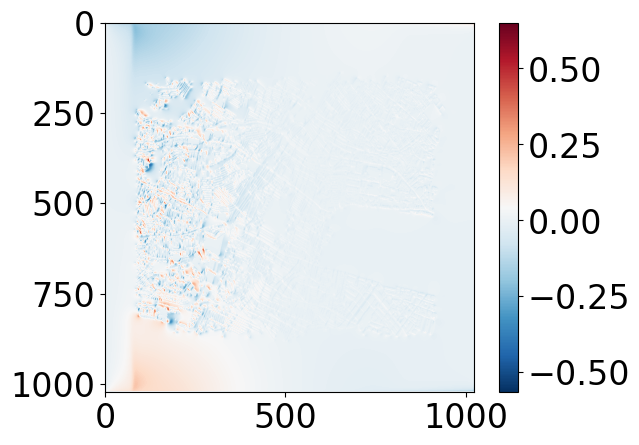

In [40]:
plt.imshow((values_v)[0,2,:,:,0], cmap='RdBu_r')
plt.colorbar()